In [30]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.stats import kruskal, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(32)
# !pip install deap
from deap import base, creator, tools
import copy
from collections import defaultdict
# import pickle
from itertools import combinations
from selection import tournament_selection, ranking_selection, roulette_wheel_selection
from mutation import mutate1, mutate2, mutate3, mutate4, mutate5, mutate6
from crossover import xo_1, xo_2, xo_3, xo_4

### Data 

Data from http://vrp.galgos.inf.puc-rio.br/index.php/en/plotted-instances?data=A-n32-k5<br>
NAME : A-n32-k5<br>
COMMENT : (Augerat et al, No of trucks: 5, Optimal value: 784)<br>
TYPE : CVRP<br>
DIMENSION : 32<br>
EDGE_WEIGHT_TYPE : EUC_2D<br>
CAPACITY : 100

In [31]:
# Dictionary with demand associated to each client (0 is the depot)
demand = {
    0: 0, 
    1: 19, 
    2: 21, 
    3: 6, 
    4: 19, 
    5: 7, 
    6: 12, 
    7: 16, 
    8: 6, 
    9: 16, 
    10: 8, 
    11: 14, 
    12: 21, 
    13: 16, 
    14: 3, 
    15: 22, 
    16: 18, 
    17: 19, 
    18: 1, 
    19: 24, 
    20: 8, 
    21: 12, 
    22: 4, 
    23: 8, 
    24: 24, 
    25: 24, 
    26: 2, 
    27: 20, 
    28: 15, 
    29: 2, 
    30: 14, 
    31: 9
}

In [32]:
# Coordinates of the location of each client and depot (1st element)
coordinates = np.array([[82, 76], 
                     [96, 44],
                     [50, 5], 
                     [49, 8], 
                     [13, 7],
                     [29, 89],
                     [58, 30],
                     [84, 39],
                     [14, 24],
                     [2, 39],
                     [3, 82],
                     [5, 10],
                     [98, 52],
                     [84, 25],
                     [61, 59],
                     [1, 65],
                     [88, 51],
                     [91, 2],
                     [19, 32],
                     [93, 3],
                     [50, 93],
                     [98, 14],
                     [5, 42],
                     [42, 9],
                     [61, 62],
                     [9, 97],
                     [80, 55],
                     [57, 69],
                     [23, 15],
                     [20, 70],
                     [85, 60],
                     [98, 5]])

In [33]:
# Get coordinates and create distance matrix
dist_matrix = distance.cdist(coordinates, coordinates, 'euclidean')

In [34]:
# Define problem variables
num_cities = 32
num_clients = num_cities - 1
num_vehicles = 5
vehicle_payload = 100

all_names = [i for i in range(num_cities)]
client_names = [i for i in range(1, num_cities)]
all_coord_dict = {name: coord for name,coord in zip(all_names, coordinates)}
client_coord_dict = {name: coord for name,coord in zip(client_names, coordinates[1:])}

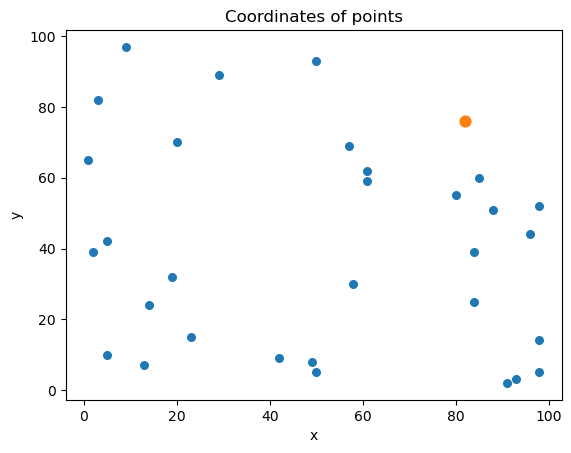

In [35]:
#Plot of the clients + depot
plot_size   = 15
plot_width  = 16
plot_height = 8

params = {'legend.fontsize': 'large',
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_size,
          'axes.titlesize': plot_size,
          'xtick.labelsize': plot_size*0.75,
          'ytick.labelsize': plot_size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.rcParams.update(params)
plt.style.use('default')
plt.scatter(coordinates[1:, 0], coordinates[1:, 1], s=plot_size*2);
plt.scatter(coordinates[0, 0], coordinates[0, 1], s=plot_size*4);
plt.title('Coordinates of points')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

### Initialization of individuals and objective: minimisation

In [ ]:
# "create" in DEAP fitness objective
tb = base.Toolbox()
creator.create('Fitness_Func', base.Fitness, weights=(-1.0,)) # minimisation
creator.create('Individual', list, fitness=creator.Fitness_Func)

In [37]:
# Function to generate individuals
def individual_create():
    """
    Function to create 2 chromosomes for each individual
    Args:
        No args. Uses previously defined client names and number of vehicles.
    Returns: 
        List with 2 lists: 
        - 1st is the "name" of the cities/customers to visit, shuffled
        - 2nd is the vehicles that visit each corresponding city
    """
    clients = copy.deepcopy(client_names)
    # Get list with random vehicle numbers with the same length as the clients list 
    vehicle = list(np.random.randint(num_vehicles, size=(len(clients))))
    # Shuffle clients
    np.random.shuffle(clients)
    # Create individual with clients and vehicles
    individual = [clients, vehicle]

    return individual

### Evaluation (fitness)

In [38]:
def calc_route_cost(_dist_matrix, _route):
    """
    Function to calculate total length of a route according to distance matrix that starts and ends in the same point.
    Args:
        _dist_matrix (list of list of floats): Distance matrix for all the points.
        _route (list of ints): Route of each vehicle.
    Returns:
        Total length of route (float)
    """  
    if not _route:
        return 3000 
    # Initialize the total distance with the distance from the last point in the route back to the starting point
    # and the distance from the starting point to the first point in the route.
    dist = dist_matrix[_route[-1], 0] + dist_matrix[0, _route[0]]
    # Iterate through each pair of consecutive points in the route.
    for p in range(len(_route) - 1):
        _i = _route[p]
        _j = _route[p + 1]
        # Add the distance between the current point and the next point to the total distance
        dist += _dist_matrix[_i][_j]

    return dist


def calc_demand(individual):
    """
    Function to map each client to their demand.
    Args:
        _individual (list of lists): list with two lists, first for clients and second for vehicles
    Returns:
        List of demands ordered according to order of clients list.
    """
    demands = [demand[client] for client in individual[0]]
    return demands


def individual_evaluate(_dist_matrix, _individual):
    """
    Function to evaluate fitness of each individual. This fitness is measured by total distance of the whole fleet of vehicles.
    Args:
        _dist_matrix (list of list of floats): Distance matrix for all the points.
        _individual (list of lists): list with two lists, first for clients and second for vehicles
    Returns:
        infinity for infeasible solutions OR total distance (float)

    """
    # Initialize route_set and demand_set with empty lists for each vehicle.
    route_set = [[] for _ in range(num_vehicles)]
    demand_set = [[] for _ in range(num_vehicles)]
    # Distribute the clients and their demands into the respective vehicle's route and demand lists.
    for s, v, d in zip(_individual[0], _individual[1], calc_demand(_individual)):
        route_set[v].append(s)
        demand_set[v].append(d)

    total_distance = 0
    for route, demands in zip(route_set, demand_set):
        # Calculate the total demand for the current vehicle.
        total_demand = sum(demands)
        # Check if the total demand exceeds the vehicle's payload capacity.
        if total_demand > vehicle_payload:
            return (float('inf'),)  # Return infinity to indicate infeasible solution, since this is a minimization problem
        # Calculate the route cost for the current vehicle and add it to the total distance.
        total_distance += calc_route_cost(_dist_matrix, route)
    
    return (total_distance,) 

In [53]:
# Get final routes
def get_route(_chromo):
    route_set = [[] for _ in range(num_vehicles)]
    for s, v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)
    return route_set

In [54]:
# Plot of the routes
def plot_routes(best_routes, title):
    plot_size = 20
    cmap = plt.cm.get_cmap('tab10', len(best_routes))
    plt.scatter(coordinates[1:, 0], coordinates[1:, 1], s=plot_size*2, c='blue') # Client locations
    plt.scatter(coordinates[0, 0], coordinates[0, 1], s=plot_size*4, c='red') # Depot location
    # Annotate the points
    for i, txt in enumerate(all_names):
        plt.annotate(txt, (coordinates[i, 0] + 0.2, coordinates[i, 1] + 0.2))
    # Plot each route with a different color
    for idx, r in enumerate(best_routes):
        route = [0] + r + [0]
        color = cmap(idx)
        for p in range(len(route) - 1):
            i = route[p]
            j = route[p + 1]
            plt.arrow(coordinates[i][0],
                    coordinates[i][1],
                    coordinates[j][0] - coordinates[i][0],
                    coordinates[j][1] - coordinates[i][1],
                    color=color, head_width=0.3, length_includes_head=True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Best solution obtained with ' + title)
    plt.show()

### Genetic algorithm

In [55]:
# Define parameters to run GA
num_population = 200
num_generations = 3000
prob_crossover = .9
prob_mutation = .15

In [56]:
def genetic_algorithm(selection_algorithm, crossover_operation, mutation_type):
    """
    Executes a genetic algorithm.
    Args:
        selection_algorithm (function): The selection algorithm to be used for selecting parents.
        crossover_operation (function): The crossover operation to be used for mating individuals.
        mutation_type (function): The mutation operation to be used for mutating individuals.
    Returns:
    best_fitness (float): The best fitness value obtained across all runs.
    best_solution (Individual): The best solution (individual) obtained across all runs.
    fitness_benchmark_all_runs (dict): A dictionary storing the best fitness at each 100 generations for all 30 runs.
    """
    # Register functions in the DEAP toolbox
    tb.register('indexes', individual_create)
    tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)
    tb.register('population', tools.initRepeat, list, tb.individual)
    tb.register('evaluate', individual_evaluate, dist_matrix)
    tb.register('select', selection_algorithm)
    tb.register('mate', crossover_operation)
    tb.register('mutate', mutation_type)

    # Generate initial population
    population = tb.population(n=num_population)
    # Calculate initial fitness of each individual
    fitness_set = list(tb.map(tb.evaluate, population))
    for ind, fit in zip(population, fitness_set):
        ind.fitness.values = fit
    # Initialize variables to track the best fitness and solutions
    overall_best_fitness = []
    fitness_benchmark_all_runs = {}  # Dictionary to store the best fitness at each 100 generations for all 30 runs
    best_fit_of_all_runs = np.inf  # Initialize with a very large number, for this is a minimization problem
    best_sol_of_all_runs = None

    for i in range(30):  # Run the algorithm 30 times
        best_fit_list = []
        fitness_benchmark = {}
        best_fit = np.inf # Minimization problem 
        best_sol = None
        num_elites = 2  # Number of elite individuals to preserve

        for gen in range(num_generations + 1):  # Iterate through generations

            if gen % 100 == 0 or gen == num_generations:
                fitness_benchmark[gen] = best_fit # Store values at each 100 generations

            # Select parents and create offspring
            offspring = tb.select(population, len(population) - num_elites)
            offspring = list(map(tb.clone, offspring))
            
            # Crossover operation
            for child1, child2 in zip(offspring[0::2], offspring[1::2]):
                if np.random.random() < prob_crossover:
                    tb.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
                    
            # Mutation operation
            for individual in offspring:
                if np.random.random() < prob_mutation:
                    tb.mutate(individual)
                    del individual.fitness.values

            # Evaluate fitness of invalid individuals
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitness_set = map(tb.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitness_set):
                ind.fitness.values = fit

            # Preserve the elite individuals
            elite_ind = tools.selBest(population, num_elites)

            # Update population with offspring and elites
            population[:] = offspring + elite_ind

            # Find the best solution in the current population
            curr_best_sol = tools.selBest(population, 1)[0]
            curr_best_fit = curr_best_sol.fitness.values[0]

            # Update the best solution and fitness if current best is better
            if curr_best_fit < best_fit:
                best_sol = curr_best_sol
                best_fit = curr_best_fit

            best_fit_list.append(best_fit)

        overall_best_fitness.append(best_fit)
        fitness_benchmark_all_runs[i] = fitness_benchmark

        # Update the best solution and fitness across all runs
        if best_fit < best_fit_of_all_runs:
            best_fit_of_all_runs = best_fit
            best_sol_of_all_runs = best_sol
    
    # Overall best fitness and best solution 
    best_fitness = round(best_fit_of_all_runs, 2)
    best_solution = best_sol_of_all_runs

    return best_fitness, best_solution, fitness_benchmark_all_runs

In [57]:
# Function to compute averages of fitnesses at the end of the runs for each combination of parameters
def compute_average_fitness(fitness_benchmark_all_runs):
    # Dictionary to hold lists of fitness values for each generation key
    aggregated_fitness = defaultdict(list)
    # Aggregate fitness values for each generation across all runs
    for run in fitness_benchmark_all_runs.values():
        for gen, fitness in run.items():
            aggregated_fitness[gen].append(fitness)
    # Compute the average fitness for each generation
    average_fitness = {gen: round(np.mean(fitnesses), 2) for gen, fitnesses in aggregated_fitness.items()}
    
    return average_fitness

### Results

Selection algorithm: tournament_selection. Crossover Operation: xo_1. Mutation Type: mutate1
Best fitness: 841.08. Best solution: [[15, 24, 6, 1, 22, 21, 27, 9, 29, 8, 10, 11, 12, 23, 3, 16, 2, 25, 31, 19, 17, 5, 4, 28, 13, 18, 20, 7, 30, 26, 14], [3, 0, 0, 1, 3, 1, 4, 3, 4, 3, 4, 3, 2, 0, 0, 2, 0, 4, 1, 1, 1, 4, 3, 3, 1, 3, 4, 0, 2, 0, 3]].
Average fitness benchmarks: {0: inf, 100: 843.49, 200: 841.28, 300: 841.28, 400: 841.28, 500: 841.28, 600: 841.28, 700: 841.28, 800: 841.28, 900: 841.28, 1000: 841.28, 1100: 841.08, 1200: 841.08, 1300: 841.08, 1400: 841.08, 1500: 841.08, 1600: 841.08, 1700: 841.08, 1800: 841.08, 1900: 841.08, 2000: 841.08, 2100: 841.08, 2200: 841.08, 2300: 841.08, 2400: 841.08, 2500: 841.08, 2600: 841.08, 2700: 841.08, 2800: 841.08, 2900: 841.08, 3000: 841.08}


C:\Users\joana\AppData\Local\Temp\ipykernel_7144\1101048374.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(best_routes))


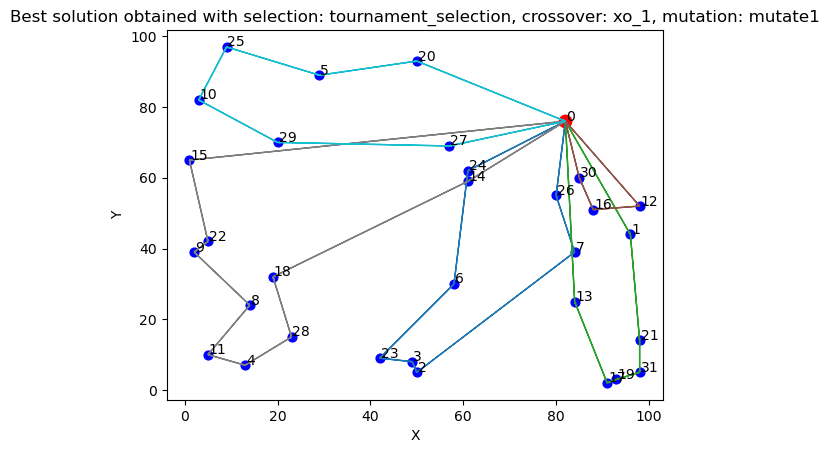

Selection algorithm: tournament_selection. Crossover Operation: xo_1. Mutation Type: mutate2
Best fitness: 892.85. Best solution: [[20, 15, 22, 12, 13, 14, 5, 25, 17, 19, 9, 18, 1, 3, 16, 31, 26, 10, 29, 21, 2, 30, 8, 11, 27, 4, 24, 28, 7, 23, 6], [1, 3, 3, 0, 4, 2, 1, 1, 4, 4, 3, 3, 0, 3, 0, 4, 0, 1, 1, 4, 3, 0, 2, 2, 1, 2, 1, 2, 4, 2, 2]].
Average fitness benchmarks: {0: inf, 100: 931.65, 200: 929.57, 300: 929.5, 400: 928.93, 500: 928.75, 600: 928.75, 700: 928.75, 800: 928.75, 900: 928.75, 1000: 928.75, 1100: 928.75, 1200: 928.75, 1300: 928.75, 1400: 928.75, 1500: 928.61, 1600: 928.32, 1700: 928.32, 1800: 928.29, 1900: 928.29, 2000: 928.29, 2100: 927.95, 2200: 927.37, 2300: 927.34, 2400: 927.28, 2500: 927.28, 2600: 927.28, 2700: 927.28, 2800: 927.28, 2900: 927.28, 3000: 927.28}


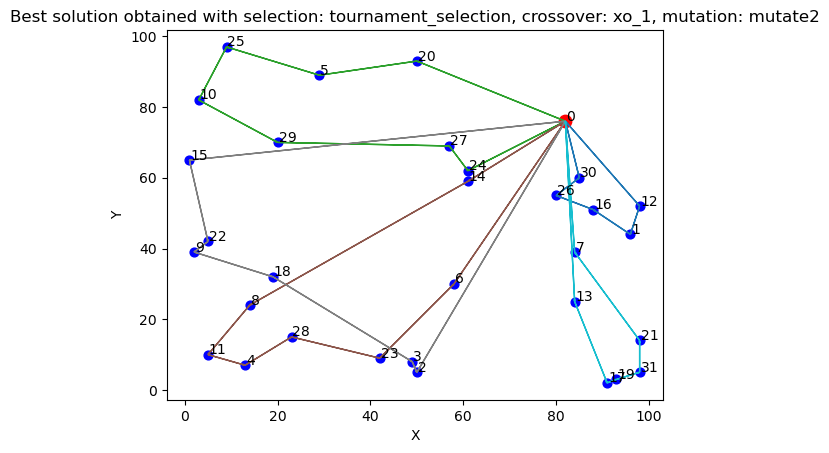

Selection algorithm: tournament_selection. Crossover Operation: xo_1. Mutation Type: mutate3
Best fitness: 1072.69. Best solution: [[18, 24, 29, 25, 16, 26, 12, 20, 1, 30, 8, 17, 2, 5, 4, 28, 19, 14, 10, 23, 15, 31, 6, 22, 21, 27, 9, 11, 13, 7, 3], [0, 1, 0, 0, 2, 3, 4, 1, 4, 2, 1, 3, 4, 0, 1, 1, 3, 1, 0, 4, 0, 3, 4, 0, 3, 1, 0, 0, 3, 3, 4]].
Average fitness benchmarks: {0: inf, 100: 1081.21, 200: 1080.35, 300: 1078.94, 400: 1078.94, 500: 1078.94, 600: 1077.68, 700: 1077.68, 800: 1077.68, 900: 1077.2, 1000: 1077.2, 1100: 1077.2, 1200: 1077.2, 1300: 1077.2, 1400: 1077.2, 1500: 1077.2, 1600: 1077.2, 1700: 1077.2, 1800: 1077.2, 1900: 1077.1, 2000: 1077.1, 2100: 1077.1, 2200: 1077.1, 2300: 1077.1, 2400: 1077.1, 2500: 1077.1, 2600: 1076.9, 2700: 1076.9, 2800: 1076.9, 2900: 1076.9, 3000: 1076.9}


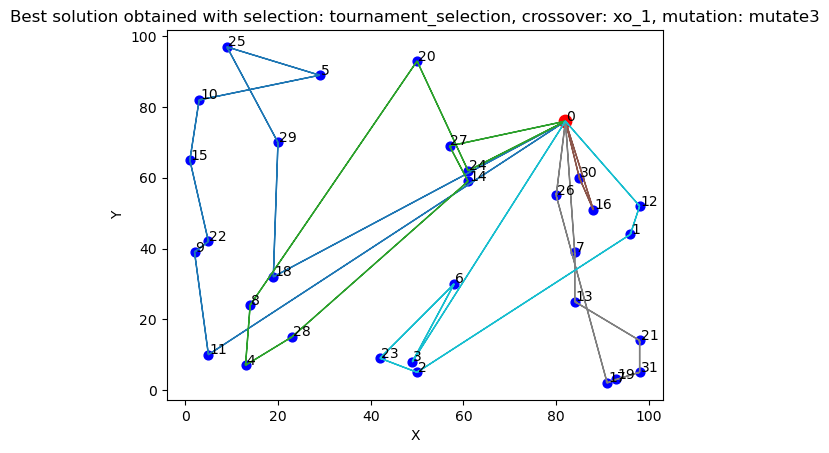

Selection algorithm: tournament_selection. Crossover Operation: xo_1. Mutation Type: mutate4
Best fitness: 995.53. Best solution: [[2, 23, 5, 28, 1, 21, 27, 31, 20, 24, 14, 30, 9, 11, 25, 19, 10, 29, 6, 4, 8, 3, 17, 18, 7, 22, 16, 15, 12, 26, 13], [2, 2, 1, 2, 0, 0, 3, 0, 4, 3, 3, 3, 4, 4, 1, 0, 1, 1, 1, 4, 2, 4, 0, 2, 4, 2, 1, 2, 1, 4, 0]].
Average fitness benchmarks: {0: inf, 100: 1011.93, 200: 1009.98, 300: 1009.56, 400: 1009.56, 500: 1009.13, 600: 1009.13, 700: 1009.05, 800: 1009.05, 900: 1008.89, 1000: 1008.89, 1100: 1008.47, 1200: 1008.47, 1300: 1008.47, 1400: 1008.47, 1500: 1008.45, 1600: 1008.45, 1700: 1006.74, 1800: 1006.74, 1900: 1006.74, 2000: 1006.62, 2100: 1004.91, 2200: 1004.91, 2300: 1004.38, 2400: 1004.36, 2500: 1004.06, 2600: 1003.66, 2700: 1003.09, 2800: 1002.95, 2900: 1002.95, 3000: 1002.95}


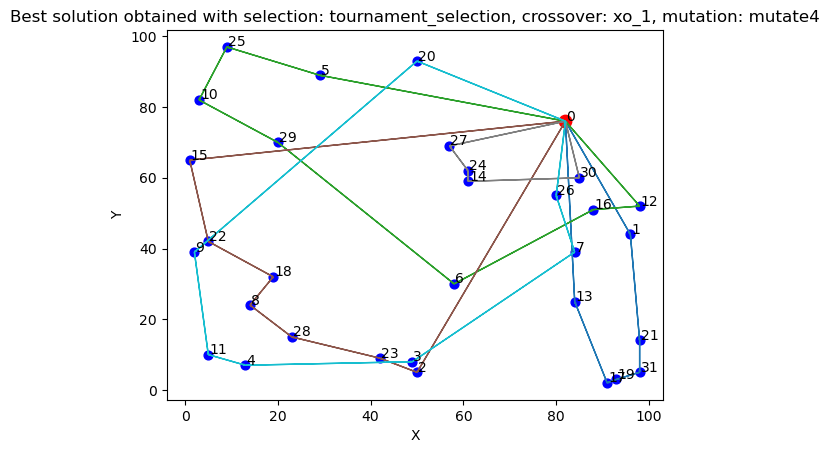

Selection algorithm: tournament_selection. Crossover Operation: xo_1. Mutation Type: mutate5
Best fitness: 926.41. Best solution: [[16, 22, 13, 17, 12, 9, 7, 8, 19, 26, 20, 6, 31, 5, 11, 3, 21, 4, 27, 1, 2, 25, 10, 24, 23, 15, 18, 29, 14, 28, 30], [1, 2, 3, 3, 4, 2, 4, 2, 3, 1, 1, 4, 3, 1, 2, 4, 3, 2, 0, 3, 4, 1, 1, 0, 4, 1, 4, 1, 0, 2, 0]].
Average fitness benchmarks: {0: inf, 100: 928.64, 200: 927.81, 300: 926.41, 400: 926.41, 500: 926.41, 600: 926.41, 700: 926.41, 800: 926.41, 900: 926.41, 1000: 926.41, 1100: 926.41, 1200: 926.41, 1300: 926.41, 1400: 926.41, 1500: 926.41, 1600: 926.41, 1700: 926.41, 1800: 926.41, 1900: 926.41, 2000: 926.41, 2100: 926.41, 2200: 926.41, 2300: 926.41, 2400: 926.41, 2500: 926.41, 2600: 926.41, 2700: 926.41, 2800: 926.41, 2900: 926.41, 3000: 926.41}


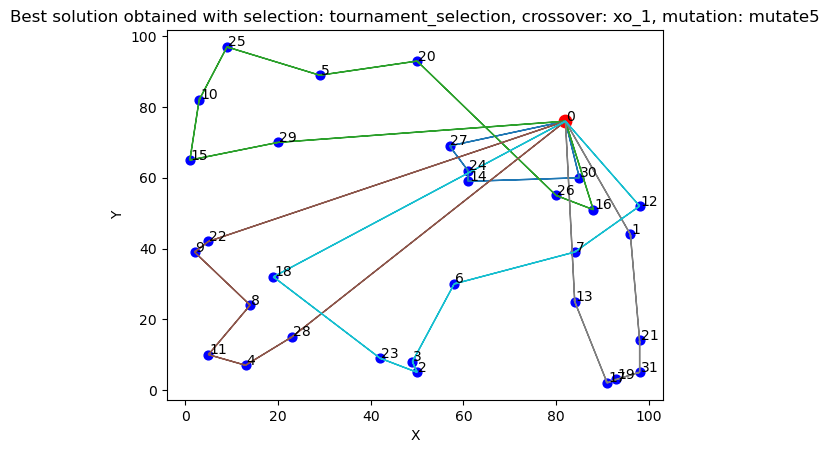

Selection algorithm: tournament_selection. Crossover Operation: xo_1. Mutation Type: mutate6
Best fitness: 1012.47. Best solution: [[26, 24, 6, 23, 13, 21, 3, 2, 22, 9, 18, 31, 19, 17, 10, 8, 25, 11, 4, 1, 28, 15, 7, 5, 12, 29, 16, 20, 14, 27, 30], [1, 0, 4, 4, 1, 1, 4, 4, 2, 2, 0, 3, 3, 3, 3, 0, 3, 0, 0, 1, 0, 2, 4, 3, 1, 2, 4, 3, 0, 2, 4]].
Average fitness benchmarks: {0: inf, 100: 1019.24, 200: 1019.04, 300: 1018.58, 400: 1017.8, 500: 1017.21, 600: 1016.46, 700: 1016.45, 800: 1016.45, 900: 1016.45, 1000: 1016.27, 1100: 1015.6, 1200: 1015.12, 1300: 1015.12, 1400: 1015.01, 1500: 1015.01, 1600: 1015.01, 1700: 1015.01, 1800: 1015.01, 1900: 1015.01, 2000: 1015.01, 2100: 1015.01, 2200: 1014.99, 2300: 1014.81, 2400: 1014.72, 2500: 1014.72, 2600: 1014.72, 2700: 1014.72, 2800: 1014.72, 2900: 1014.72, 3000: 1014.72}


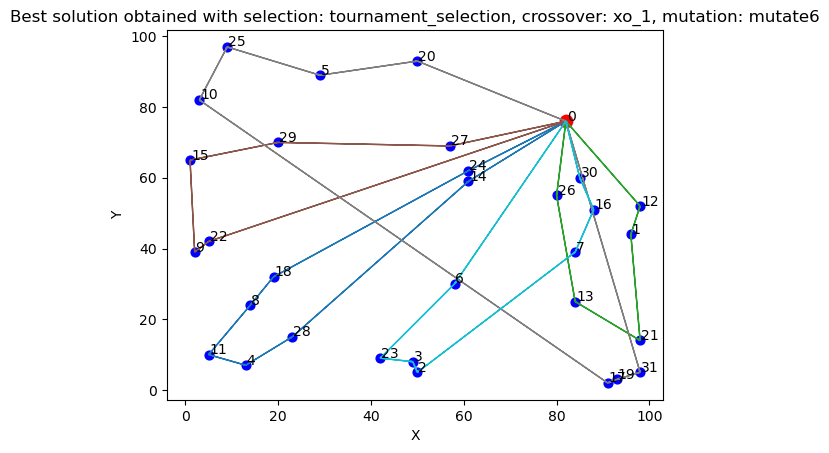

Selection algorithm: tournament_selection. Crossover Operation: xo_2. Mutation Type: mutate1
Best fitness: 862.24. Best solution: [[27, 30, 16, 6, 5, 26, 21, 24, 14, 31, 28, 11, 18, 4, 10, 25, 23, 19, 8, 17, 1, 13, 2, 12, 9, 20, 22, 15, 7, 29, 3], [3, 2, 2, 1, 3, 0, 0, 4, 4, 0, 1, 1, 4, 1, 3, 3, 1, 0, 4, 0, 2, 0, 1, 2, 4, 3, 4, 4, 0, 4, 1]].
Average fitness benchmarks: {0: inf, 100: 868.89, 200: 866.96, 300: 866.06, 400: 865.67, 500: 863.7, 600: 862.25, 700: 862.25, 800: 862.24, 900: 862.24, 1000: 862.24, 1100: 862.24, 1200: 862.24, 1300: 862.24, 1400: 862.24, 1500: 862.24, 1600: 862.24, 1700: 862.24, 1800: 862.24, 1900: 862.24, 2000: 862.24, 2100: 862.24, 2200: 862.24, 2300: 862.24, 2400: 862.24, 2500: 862.24, 2600: 862.24, 2700: 862.24, 2800: 862.24, 2900: 862.24, 3000: 862.24}


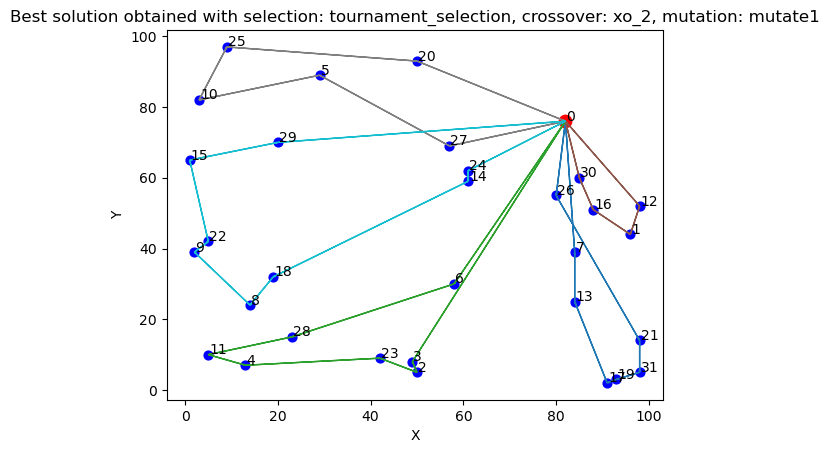

Selection algorithm: tournament_selection. Crossover Operation: xo_2. Mutation Type: mutate2
Best fitness: 894.39. Best solution: [[7, 6, 20, 13, 30, 12, 8, 17, 11, 3, 5, 19, 29, 1, 2, 16, 4, 26, 28, 24, 31, 18, 9, 21, 22, 23, 15, 10, 25, 14, 27], [0, 2, 4, 0, 1, 1, 3, 0, 3, 2, 4, 0, 4, 1, 2, 1, 3, 1, 3, 3, 0, 4, 4, 0, 4, 2, 4, 4, 4, 2, 3]].
Average fitness benchmarks: {0: inf, 100: 906.57, 200: 900.01, 300: 897.94, 400: 895.34, 500: 894.64, 600: 894.58, 700: 894.45, 800: 894.41, 900: 894.41, 1000: 894.41, 1100: 894.39, 1200: 894.39, 1300: 894.39, 1400: 894.39, 1500: 894.39, 1600: 894.39, 1700: 894.39, 1800: 894.39, 1900: 894.39, 2000: 894.39, 2100: 894.39, 2200: 894.39, 2300: 894.39, 2400: 894.39, 2500: 894.39, 2600: 894.39, 2700: 894.39, 2800: 894.39, 2900: 894.39, 3000: 894.39}


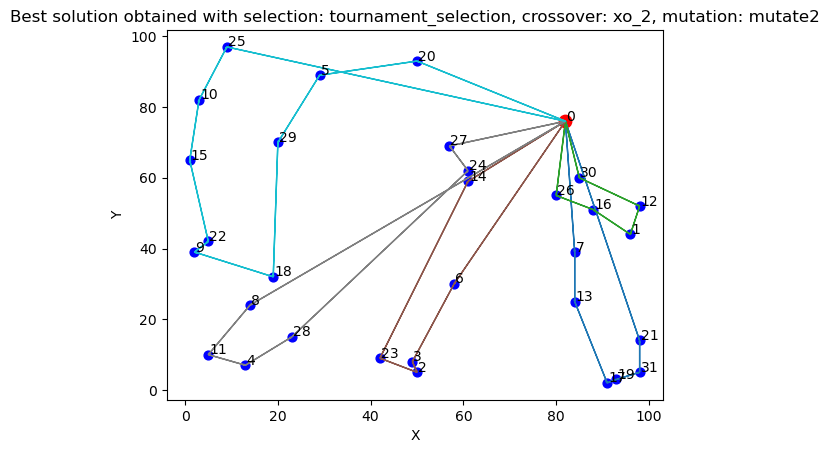

Selection algorithm: tournament_selection. Crossover Operation: xo_2. Mutation Type: mutate3
Best fitness: 897.86. Best solution: [[14, 18, 27, 25, 10, 6, 28, 3, 4, 1, 2, 23, 13, 17, 11, 15, 19, 12, 7, 8, 31, 24, 20, 26, 9, 30, 21, 22, 29, 5, 16], [0, 0, 3, 3, 3, 4, 0, 4, 0, 1, 4, 4, 2, 2, 0, 3, 2, 1, 1, 0, 2, 4, 3, 1, 0, 1, 2, 0, 0, 0, 2]].
Average fitness benchmarks: {0: inf, 100: 913.68, 200: 912.2, 300: 911.01, 400: 911.01, 500: 910.95, 600: 909.26, 700: 906.97, 800: 906.97, 900: 906.97, 1000: 906.95, 1100: 906.95, 1200: 906.95, 1300: 906.95, 1400: 906.95, 1500: 906.95, 1600: 906.95, 1700: 906.95, 1800: 906.89, 1900: 906.89, 2000: 906.33, 2100: 904.76, 2200: 904.76, 2300: 904.76, 2400: 904.76, 2500: 904.76, 2600: 904.25, 2700: 904.25, 2800: 904.25, 2900: 904.25, 3000: 904.25}


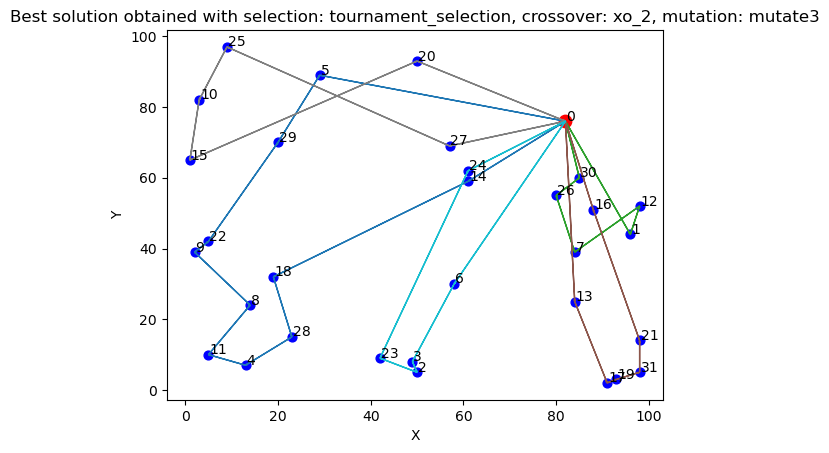

Selection algorithm: tournament_selection. Crossover Operation: xo_2. Mutation Type: mutate4
Best fitness: 959.94. Best solution: [[14, 6, 28, 20, 4, 1, 19, 11, 29, 8, 24, 15, 16, 3, 27, 9, 17, 31, 26, 30, 5, 2, 22, 21, 12, 23, 13, 25, 7, 18, 10], [0, 0, 0, 2, 0, 4, 3, 0, 2, 0, 1, 2, 4, 2, 1, 0, 3, 3, 4, 4, 1, 2, 0, 3, 4, 2, 3, 1, 3, 0, 1]].
Average fitness benchmarks: {0: inf, 100: 969.06, 200: 967.53, 300: 967.37, 400: 966.48, 500: 965.28, 600: 965.28, 700: 965.28, 800: 965.28, 900: 965.28, 1000: 965.26, 1100: 965.26, 1200: 965.26, 1300: 965.26, 1400: 965.26, 1500: 965.26, 1600: 965.26, 1700: 965.26, 1800: 965.26, 1900: 965.26, 2000: 965.26, 2100: 965.26, 2200: 965.26, 2300: 965.26, 2400: 964.59, 2500: 962.62, 2600: 962.62, 2700: 962.62, 2800: 962.62, 2900: 962.62, 3000: 962.62}


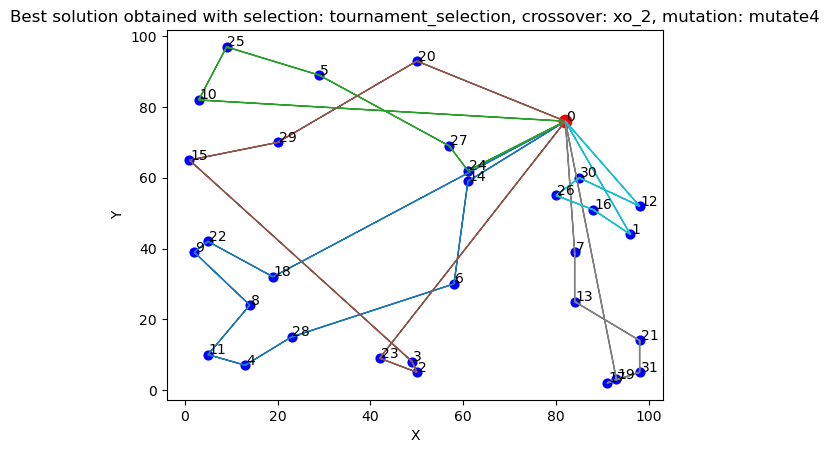

Selection algorithm: tournament_selection. Crossover Operation: xo_2. Mutation Type: mutate5
Best fitness: 986.32. Best solution: [[11, 24, 26, 18, 27, 22, 29, 17, 15, 10, 25, 19, 9, 4, 6, 31, 5, 7, 16, 21, 3, 8, 28, 12, 20, 2, 23, 13, 14, 1, 30], [0, 2, 3, 2, 1, 2, 1, 3, 1, 1, 1, 3, 2, 0, 4, 3, 1, 0, 0, 3, 4, 2, 2, 3, 1, 4, 2, 4, 2, 4, 0]].
Average fitness benchmarks: {0: inf, 100: 988.83, 200: 986.91, 300: 986.32, 400: 986.32, 500: 986.32, 600: 986.32, 700: 986.32, 800: 986.32, 900: 986.32, 1000: 986.32, 1100: 986.32, 1200: 986.32, 1300: 986.32, 1400: 986.32, 1500: 986.32, 1600: 986.32, 1700: 986.32, 1800: 986.32, 1900: 986.32, 2000: 986.32, 2100: 986.32, 2200: 986.32, 2300: 986.32, 2400: 986.32, 2500: 986.32, 2600: 986.32, 2700: 986.32, 2800: 986.32, 2900: 986.32, 3000: 986.32}


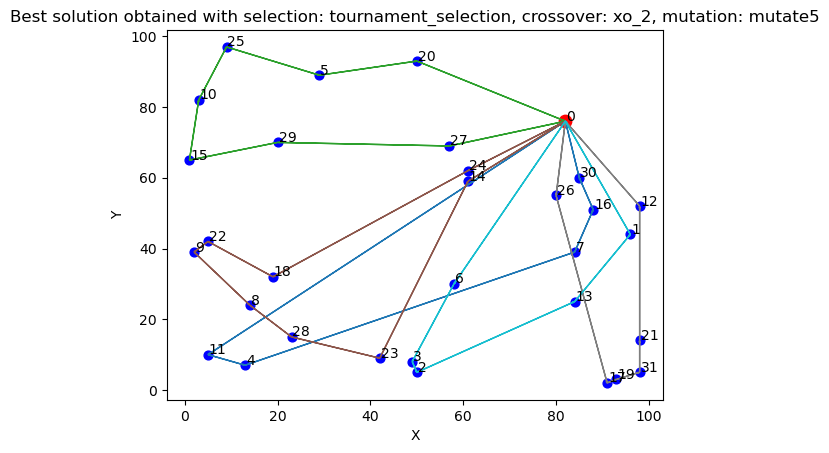

Selection algorithm: tournament_selection. Crossover Operation: xo_2. Mutation Type: mutate6
Best fitness: 870.01. Best solution: [[31, 14, 12, 6, 20, 23, 5, 19, 1, 28, 25, 21, 13, 10, 15, 7, 17, 9, 2, 24, 22, 27, 4, 11, 8, 3, 29, 26, 16, 30, 18], [1, 4, 2, 4, 3, 4, 3, 1, 2, 4, 3, 2, 2, 3, 3, 2, 1, 3, 1, 0, 3, 0, 4, 4, 4, 1, 3, 2, 1, 2, 4]].
Average fitness benchmarks: {0: inf, 100: 886.89, 200: 884.5, 300: 883.17, 400: 882.74, 500: 880.59, 600: 879.55, 700: 879.55, 800: 879.55, 900: 879.55, 1000: 879.42, 1100: 879.42, 1200: 879.42, 1300: 879.42, 1400: 879.42, 1500: 879.42, 1600: 879.2, 1700: 879.2, 1800: 879.2, 1900: 879.14, 2000: 879.14, 2100: 879.14, 2200: 879.06, 2300: 879.06, 2400: 879.06, 2500: 878.81, 2600: 878.8, 2700: 878.79, 2800: 878.77, 2900: 878.49, 3000: 876.57}


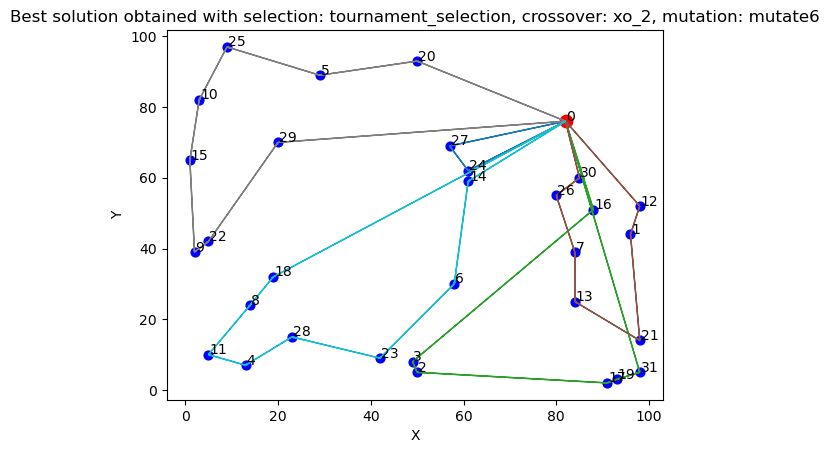

Selection algorithm: tournament_selection. Crossover Operation: xo_3. Mutation Type: mutate1
Best fitness: 815.16. Best solution: [[13, 27, 17, 20, 19, 30, 29, 5, 15, 31, 22, 25, 10, 18, 23, 24, 21, 7, 26, 2, 14, 9, 8, 11, 16, 3, 4, 1, 6, 28, 12], [4, 1, 4, 2, 4, 0, 3, 2, 3, 4, 3, 2, 2, 2, 2, 1, 4, 4, 4, 2, 1, 3, 3, 3, 0, 2, 3, 0, 2, 3, 0]].
Average fitness benchmarks: {0: inf, 100: 820.39, 200: 820.39, 300: 820.33, 400: 820.27, 500: 820.27, 600: 820.27, 700: 819.54, 800: 819.33, 900: 819.33, 1000: 819.33, 1100: 819.33, 1200: 819.33, 1300: 819.33, 1400: 819.33, 1500: 819.33, 1600: 819.33, 1700: 819.33, 1800: 819.33, 1900: 819.33, 2000: 819.26, 2100: 819.26, 2200: 819.26, 2300: 818.87, 2400: 818.87, 2500: 818.87, 2600: 818.87, 2700: 815.16, 2800: 815.16, 2900: 815.16, 3000: 815.16}


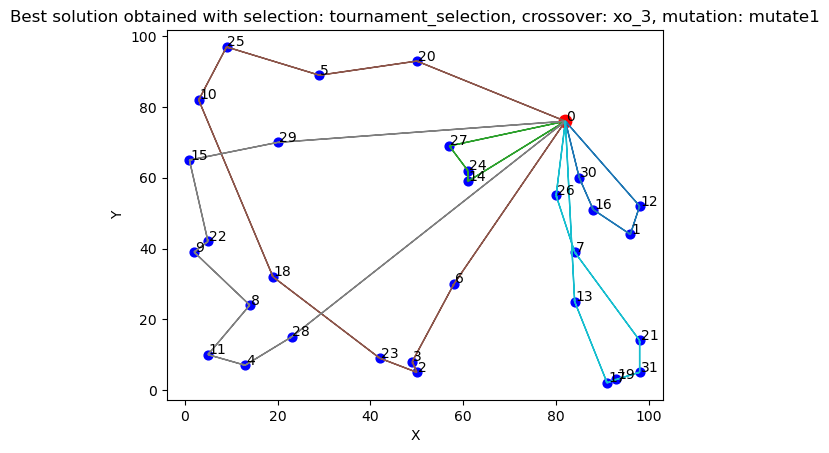

Selection algorithm: tournament_selection. Crossover Operation: xo_3. Mutation Type: mutate2
Best fitness: 976.57. Best solution: [[19, 30, 17, 22, 26, 9, 11, 20, 3, 5, 6, 29, 23, 16, 12, 15, 4, 14, 2, 24, 10, 1, 13, 25, 7, 31, 27, 28, 21, 8, 18], [4, 2, 4, 1, 2, 1, 1, 0, 4, 0, 2, 0, 4, 3, 3, 0, 1, 2, 1, 2, 0, 3, 3, 0, 3, 1, 2, 4, 1, 4, 4]].
Average fitness benchmarks: {0: inf, 100: 986.22, 200: 981.39, 300: 979.79, 400: 978.96, 500: 978.96, 600: 978.96, 700: 978.96, 800: 978.96, 900: 978.96, 1000: 978.96, 1100: 978.96, 1200: 978.96, 1300: 978.96, 1400: 978.96, 1500: 978.96, 1600: 978.96, 1700: 978.96, 1800: 978.96, 1900: 976.8, 2000: 976.57, 2100: 976.57, 2200: 976.57, 2300: 976.57, 2400: 976.57, 2500: 976.57, 2600: 976.57, 2700: 976.57, 2800: 976.57, 2900: 976.57, 3000: 976.57}


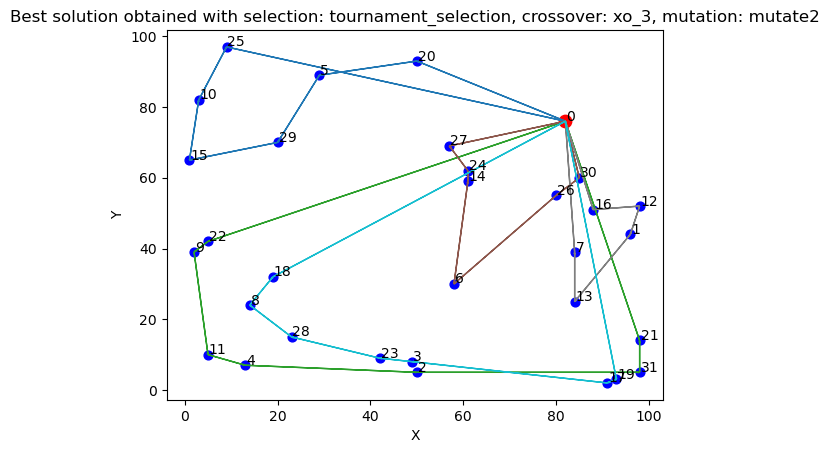

Selection algorithm: tournament_selection. Crossover Operation: xo_3. Mutation Type: mutate3
Best fitness: 976.94. Best solution: [[30, 26, 14, 27, 12, 19, 5, 15, 28, 22, 11, 2, 4, 21, 20, 3, 25, 8, 23, 7, 9, 10, 31, 16, 6, 13, 18, 29, 24, 1, 17], [3, 3, 0, 2, 4, 4, 1, 1, 0, 1, 1, 0, 1, 4, 2, 0, 2, 1, 0, 3, 1, 2, 4, 3, 0, 0, 1, 2, 2, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 990.35, 200: 984.57, 300: 983.35, 400: 983.21, 500: 983.14, 600: 983.14, 700: 983.0, 800: 983.0, 900: 983.0, 1000: 983.0, 1100: 983.0, 1200: 983.0, 1300: 983.0, 1400: 983.0, 1500: 982.08, 1600: 981.84, 1700: 981.84, 1800: 981.84, 1900: 981.84, 2000: 981.72, 2100: 981.72, 2200: 981.23, 2300: 981.23, 2400: 981.12, 2500: 981.12, 2600: 981.12, 2700: 981.12, 2800: 981.12, 2900: 981.12, 3000: 981.12}


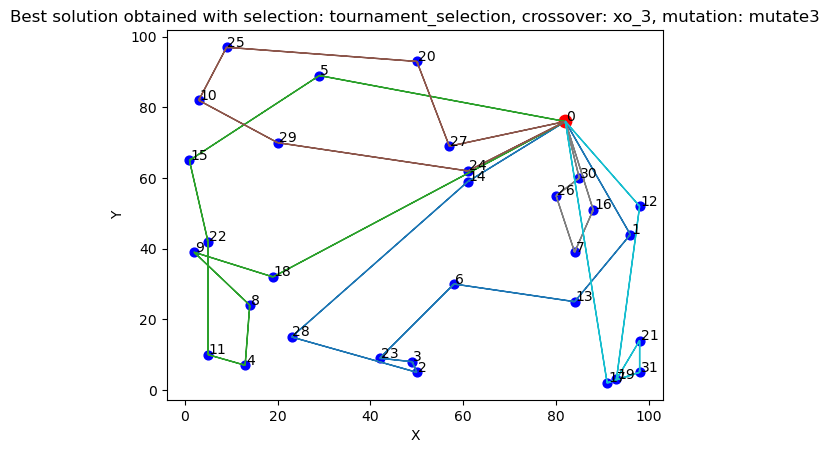

Selection algorithm: tournament_selection. Crossover Operation: xo_3. Mutation Type: mutate4
Best fitness: 1026.55. Best solution: [[16, 27, 6, 31, 10, 7, 19, 3, 23, 28, 9, 22, 4, 18, 12, 26, 29, 14, 25, 24, 5, 17, 21, 13, 15, 8, 11, 2, 30, 20, 1], [1, 2, 4, 0, 3, 1, 0, 4, 4, 4, 2, 2, 4, 4, 1, 1, 2, 1, 2, 1, 2, 0, 0, 0, 3, 3, 3, 3, 3, 2, 0]].
Average fitness benchmarks: {0: inf, 100: 1042.35, 200: 1041.0, 300: 1039.66, 400: 1039.21, 500: 1037.53, 600: 1037.31, 700: 1037.31, 800: 1037.31, 900: 1037.06, 1000: 1037.06, 1100: 1036.98, 1200: 1036.6, 1300: 1036.57, 1400: 1036.57, 1500: 1036.57, 1600: 1036.57, 1700: 1036.57, 1800: 1036.57, 1900: 1036.57, 2000: 1036.57, 2100: 1036.55, 2200: 1036.55, 2300: 1036.55, 2400: 1036.54, 2500: 1036.54, 2600: 1036.54, 2700: 1036.54, 2800: 1036.54, 2900: 1036.54, 3000: 1036.54}


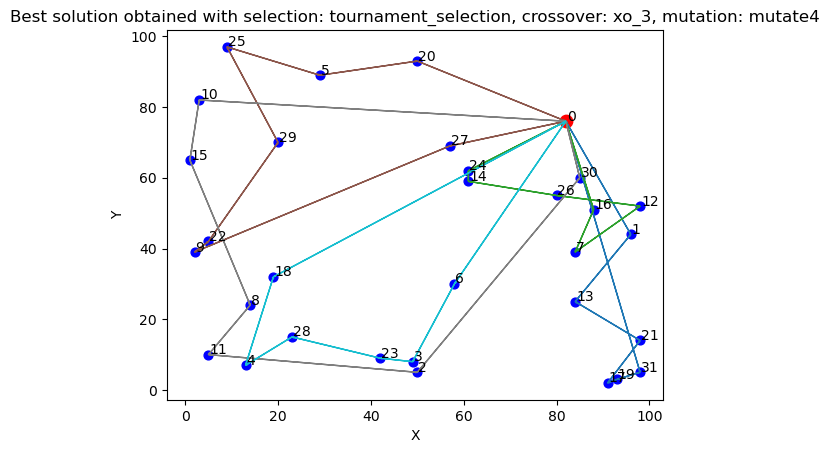

Selection algorithm: tournament_selection. Crossover Operation: xo_3. Mutation Type: mutate5
Best fitness: 933.95. Best solution: [[6, 3, 5, 2, 30, 26, 25, 10, 28, 16, 8, 1, 18, 27, 9, 12, 7, 24, 22, 15, 21, 31, 14, 29, 19, 23, 17, 20, 13, 4, 11], [1, 1, 0, 1, 2, 4, 0, 0, 2, 0, 2, 0, 2, 3, 2, 0, 4, 3, 2, 2, 4, 4, 3, 2, 4, 1, 4, 2, 4, 1, 1]].
Average fitness benchmarks: {0: inf, 100: 936.42, 200: 935.43, 300: 934.42, 400: 934.03, 500: 933.95, 600: 933.95, 700: 933.95, 800: 933.95, 900: 933.95, 1000: 933.95, 1100: 933.95, 1200: 933.95, 1300: 933.95, 1400: 933.95, 1500: 933.95, 1600: 933.95, 1700: 933.95, 1800: 933.95, 1900: 933.95, 2000: 933.95, 2100: 933.95, 2200: 933.95, 2300: 933.95, 2400: 933.95, 2500: 933.95, 2600: 933.95, 2700: 933.95, 2800: 933.95, 2900: 933.95, 3000: 933.95}


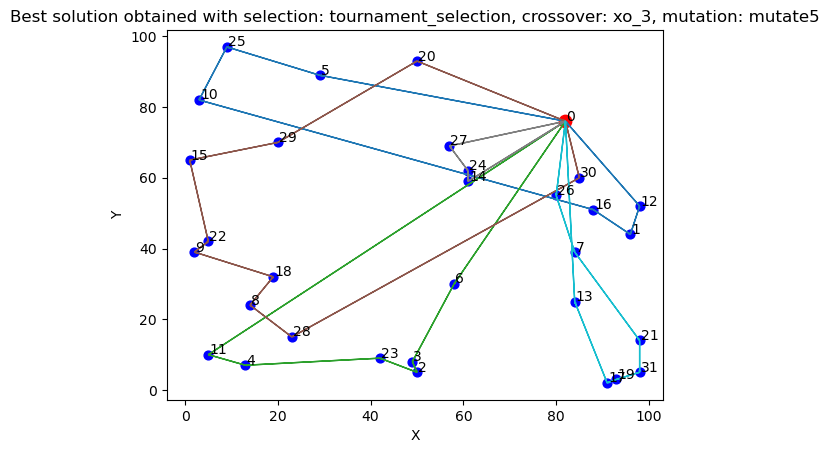

Selection algorithm: tournament_selection. Crossover Operation: xo_3. Mutation Type: mutate6
Best fitness: 845.56. Best solution: [[22, 23, 9, 27, 11, 4, 29, 12, 1, 3, 15, 7, 13, 2, 17, 26, 10, 19, 6, 25, 5, 20, 14, 28, 31, 8, 18, 24, 21, 16, 30], [0, 4, 0, 1, 0, 0, 1, 3, 3, 4, 1, 3, 3, 4, 4, 2, 1, 4, 3, 1, 1, 1, 3, 0, 4, 0, 0, 0, 4, 2, 2]].
Average fitness benchmarks: {0: inf, 100: 866.64, 200: 860.69, 300: 857.46, 400: 856.99, 500: 855.82, 600: 855.49, 700: 855.49, 800: 855.49, 900: 855.49, 1000: 855.42, 1100: 855.42, 1200: 854.95, 1300: 854.54, 1400: 854.54, 1500: 854.42, 1600: 853.71, 1700: 853.71, 1800: 853.66, 1900: 853.66, 2000: 853.66, 2100: 853.66, 2200: 853.66, 2300: 853.66, 2400: 853.66, 2500: 853.66, 2600: 853.66, 2700: 853.66, 2800: 853.66, 2900: 853.66, 3000: 853.66}


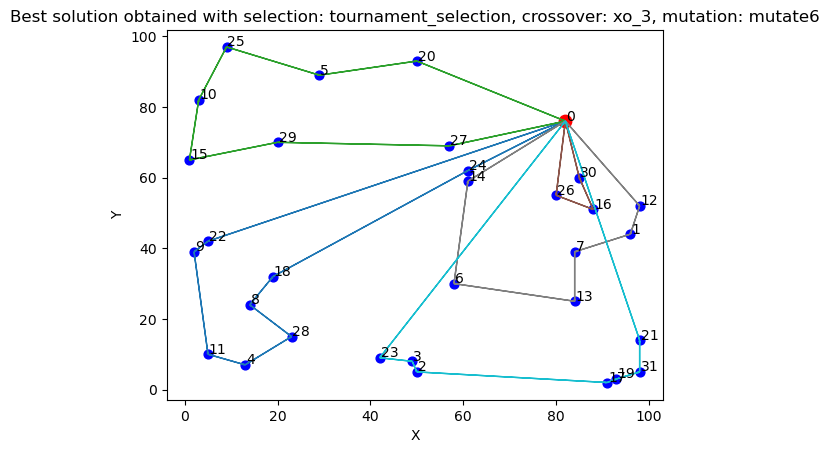

Selection algorithm: tournament_selection. Crossover Operation: xo_4. Mutation Type: mutate1
Best fitness: 834.86. Best solution: [[30, 6, 14, 20, 13, 16, 3, 28, 5, 17, 19, 4, 2, 11, 25, 8, 23, 24, 18, 31, 1, 9, 12, 22, 27, 10, 15, 21, 7, 26, 29], [3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 0, 1, 2, 1, 4, 1, 2, 2, 1, 0, 3, 1, 3, 1, 1, 4, 4, 0, 0, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 843.54, 200: 841.48, 300: 838.59, 400: 838.54, 500: 838.49, 600: 837.99, 700: 837.97, 800: 837.76, 900: 837.76, 1000: 837.76, 1100: 837.76, 1200: 837.15, 1300: 836.87, 1400: 836.87, 1500: 836.87, 1600: 836.87, 1700: 836.87, 1800: 836.87, 1900: 836.87, 2000: 836.87, 2100: 836.87, 2200: 836.76, 2300: 836.76, 2400: 836.76, 2500: 836.76, 2600: 836.76, 2700: 836.76, 2800: 836.76, 2900: 836.76, 3000: 836.76}


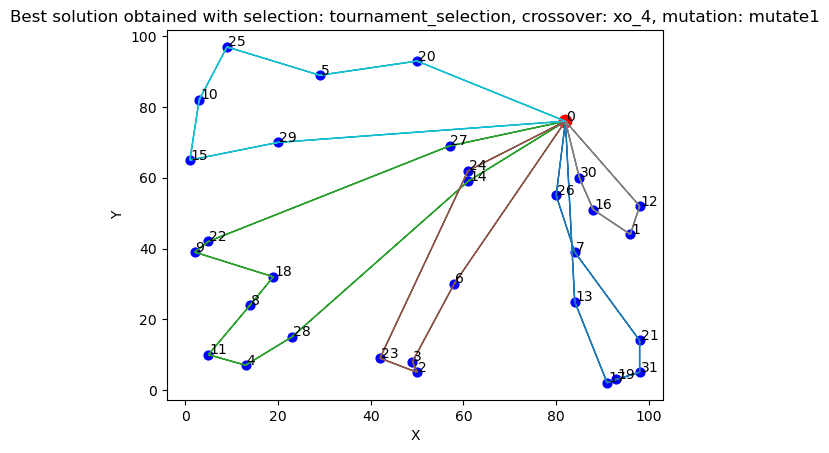

Selection algorithm: tournament_selection. Crossover Operation: xo_4. Mutation Type: mutate2
Best fitness: 926.35. Best solution: [[31, 30, 28, 5, 26, 4, 11, 8, 25, 16, 19, 24, 27, 1, 12, 10, 14, 15, 22, 17, 2, 9, 18, 13, 3, 21, 29, 23, 6, 7, 20], [2, 3, 1, 0, 3, 1, 1, 1, 0, 3, 2, 1, 1, 3, 3, 0, 4, 0, 0, 2, 2, 0, 0, 4, 2, 4, 0, 2, 2, 4, 0]].
Average fitness benchmarks: {0: inf, 100: 934.21, 200: 930.0, 300: 928.42, 400: 927.98, 500: 926.57, 600: 926.57, 700: 926.57, 800: 926.57, 900: 926.57, 1000: 926.35, 1100: 926.35, 1200: 926.35, 1300: 926.35, 1400: 926.35, 1500: 926.35, 1600: 926.35, 1700: 926.35, 1800: 926.35, 1900: 926.35, 2000: 926.35, 2100: 926.35, 2200: 926.35, 2300: 926.35, 2400: 926.35, 2500: 926.35, 2600: 926.35, 2700: 926.35, 2800: 926.35, 2900: 926.35, 3000: 926.35}


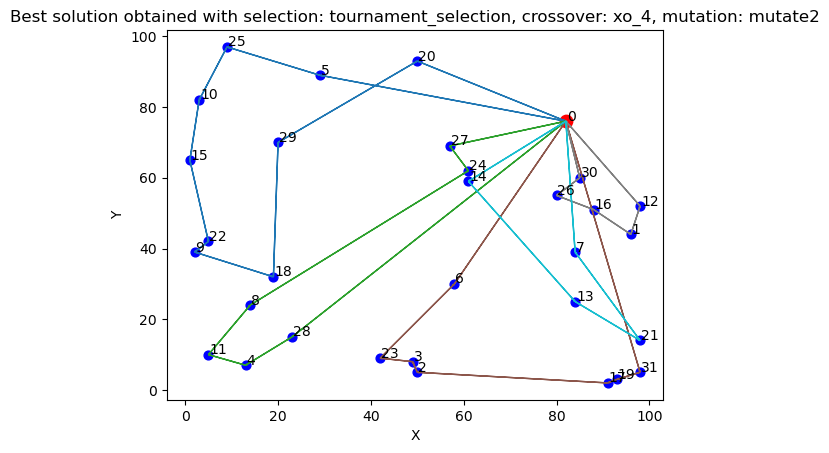

Selection algorithm: tournament_selection. Crossover Operation: xo_4. Mutation Type: mutate3
Best fitness: 965.66. Best solution: [[24, 14, 18, 23, 16, 27, 1, 20, 4, 11, 15, 30, 22, 9, 5, 8, 3, 10, 26, 13, 21, 31, 19, 28, 6, 7, 12, 17, 25, 29, 2], [0, 1, 1, 1, 4, 0, 4, 3, 1, 1, 3, 2, 3, 3, 0, 3, 3, 0, 2, 2, 2, 2, 2, 1, 1, 1, 4, 2, 0, 0, 3]].
Average fitness benchmarks: {0: inf, 100: 986.75, 200: 985.72, 300: 984.3, 400: 984.3, 500: 982.46, 600: 982.27, 700: 981.98, 800: 981.98, 900: 981.61, 1000: 981.61, 1100: 981.61, 1200: 981.61, 1300: 981.61, 1400: 981.61, 1500: 981.61, 1600: 981.61, 1700: 981.61, 1800: 981.61, 1900: 981.61, 2000: 981.61, 2100: 981.61, 2200: 981.61, 2300: 981.61, 2400: 981.61, 2500: 981.61, 2600: 981.19, 2700: 981.16, 2800: 980.85, 2900: 979.76, 3000: 979.76}


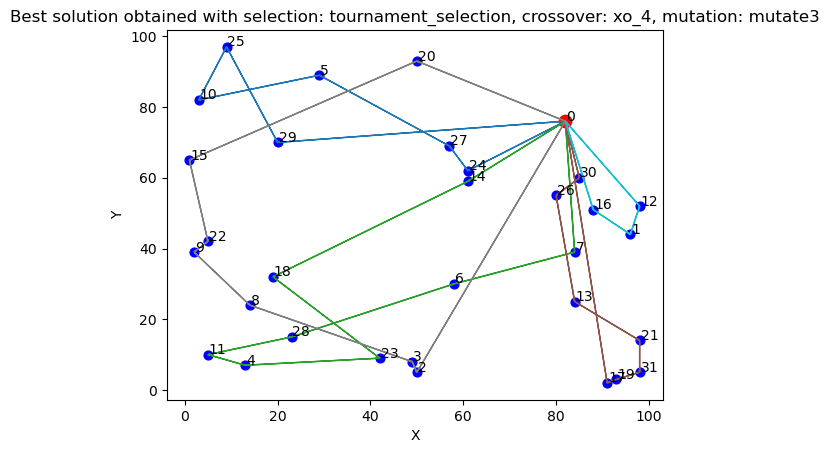

Selection algorithm: tournament_selection. Crossover Operation: xo_4. Mutation Type: mutate4
Best fitness: 991.5. Best solution: [[16, 11, 19, 20, 17, 5, 25, 10, 15, 12, 29, 2, 7, 1, 3, 30, 18, 21, 26, 8, 31, 13, 28, 6, 24, 23, 4, 9, 27, 22, 14], [4, 3, 4, 2, 4, 2, 2, 2, 2, 0, 2, 3, 4, 0, 3, 1, 2, 0, 4, 2, 0, 0, 2, 0, 1, 3, 3, 3, 1, 3, 3]].
Average fitness benchmarks: {0: inf, 100: 1027.6, 200: 1026.52, 300: 1026.48, 400: 1026.06, 500: 1026.06, 600: 1025.78, 700: 1025.78, 800: 1025.78, 900: 1025.78, 1000: 1025.78, 1100: 1025.78, 1200: 1025.78, 1300: 1025.4, 1400: 1025.4, 1500: 1025.19, 1600: 1024.27, 1700: 1022.62, 1800: 1022.21, 1900: 1022.19, 2000: 1022.19, 2100: 1022.19, 2200: 1022.19, 2300: 1022.19, 2400: 1022.19, 2500: 1022.19, 2600: 1022.19, 2700: 1021.95, 2800: 1021.66, 2900: 1021.66, 3000: 1021.66}


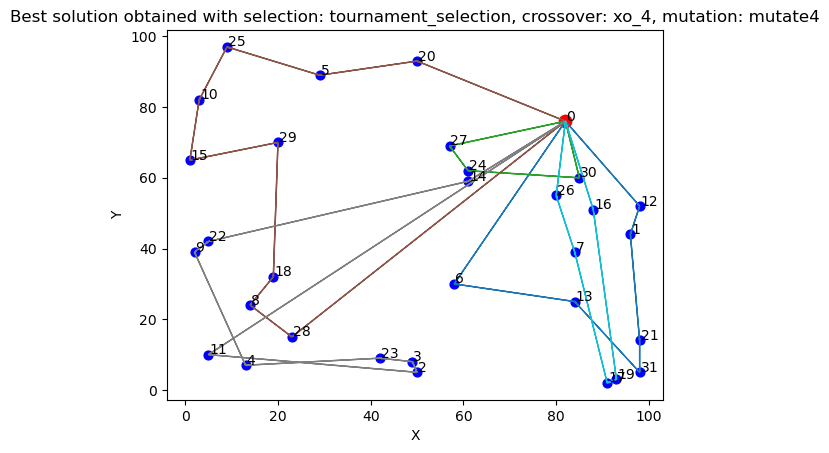

Selection algorithm: tournament_selection. Crossover Operation: xo_4. Mutation Type: mutate5
Best fitness: 877.88. Best solution: [[6, 3, 20, 2, 24, 5, 21, 25, 23, 18, 12, 28, 1, 31, 4, 10, 19, 29, 17, 8, 11, 13, 7, 9, 27, 22, 16, 26, 30, 14, 15], [1, 1, 2, 1, 0, 2, 3, 2, 1, 0, 4, 1, 4, 3, 1, 2, 3, 2, 3, 0, 1, 3, 3, 0, 2, 0, 4, 2, 2, 1, 0]].
Average fitness benchmarks: {0: inf, 100: 883.91, 200: 880.44, 300: 880.12, 400: 880.12, 500: 880.12, 600: 880.12, 700: 880.12, 800: 880.12, 900: 880.12, 1000: 880.12, 1100: 880.12, 1200: 880.12, 1300: 880.12, 1400: 880.12, 1500: 880.12, 1600: 880.12, 1700: 880.12, 1800: 880.12, 1900: 880.12, 2000: 880.12, 2100: 880.12, 2200: 880.12, 2300: 880.12, 2400: 880.12, 2500: 877.88, 2600: 877.88, 2700: 877.88, 2800: 877.88, 2900: 877.88, 3000: 877.88}


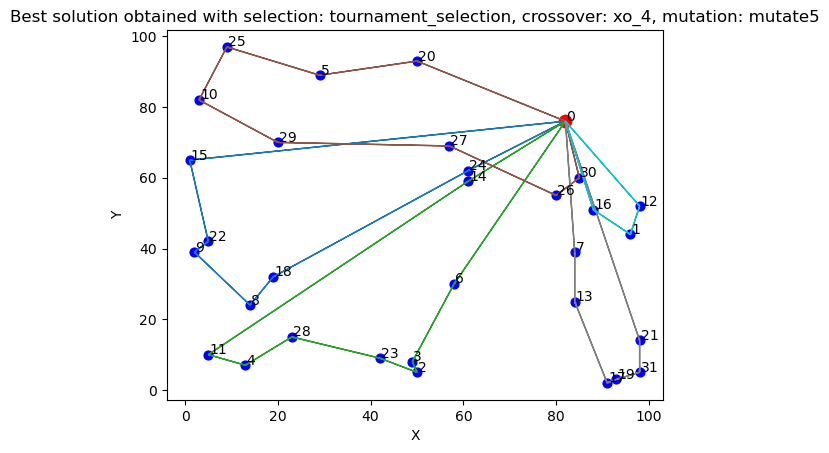

Selection algorithm: tournament_selection. Crossover Operation: xo_4. Mutation Type: mutate6
Best fitness: 788.39. Best solution: [[26, 21, 31, 20, 5, 27, 25, 6, 3, 19, 30, 24, 10, 2, 17, 13, 29, 23, 15, 4, 16, 11, 7, 22, 28, 1, 9, 12, 8, 18, 14], [2, 2, 2, 1, 1, 0, 1, 3, 3, 2, 4, 0, 1, 3, 2, 2, 1, 3, 1, 3, 4, 3, 2, 1, 3, 4, 1, 4, 1, 1, 3]].
Average fitness benchmarks: {0: inf, 100: 802.44, 200: 800.67, 300: 800.32, 400: 799.84, 500: 799.39, 600: 799.17, 700: 798.93, 800: 797.61, 900: 796.83, 1000: 796.76, 1100: 796.74, 1200: 796.74, 1300: 796.59, 1400: 796.59, 1500: 796.59, 1600: 796.59, 1700: 796.59, 1800: 796.59, 1900: 796.06, 2000: 796.06, 2100: 796.06, 2200: 796.06, 2300: 796.06, 2400: 795.75, 2500: 795.75, 2600: 795.75, 2700: 795.75, 2800: 795.66, 2900: 795.64, 3000: 795.64}


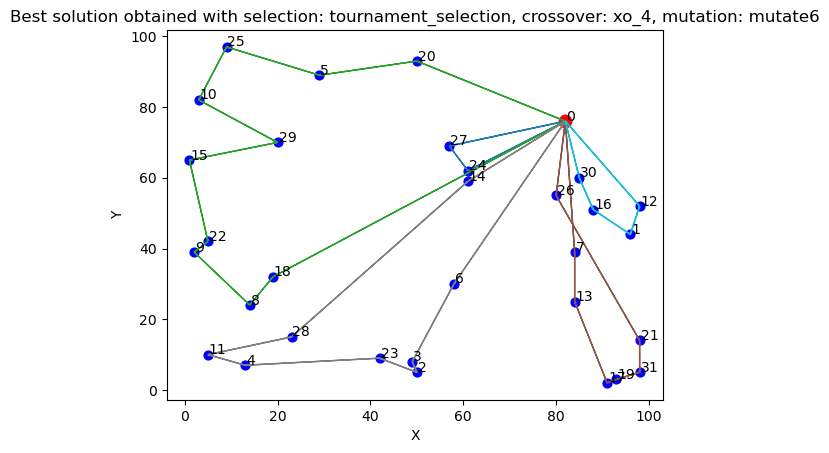

Selection algorithm: ranking_selection. Crossover Operation: xo_1. Mutation Type: mutate1
Best fitness: 865.95. Best solution: [[13, 12, 17, 22, 26, 1, 6, 9, 7, 20, 3, 19, 16, 5, 8, 25, 10, 31, 2, 23, 18, 15, 30, 14, 21, 4, 11, 24, 29, 27, 28], [4, 0, 4, 2, 3, 0, 3, 2, 0, 1, 3, 4, 0, 1, 2, 1, 1, 4, 3, 3, 2, 1, 0, 2, 4, 3, 3, 2, 1, 1, 3]].
Average fitness benchmarks: {0: inf, 100: 899.02, 200: 898.67, 300: 895.27, 400: 893.64, 500: 890.03, 600: 887.79, 700: 887.59, 800: 887.32, 900: 886.95, 1000: 886.81, 1100: 886.81, 1200: 885.84, 1300: 884.11, 1400: 883.58, 1500: 883.26, 1600: 882.61, 1700: 882.41, 1800: 882.41, 1900: 881.94, 2000: 881.94, 2100: 881.58, 2200: 880.76, 2300: 879.64, 2400: 879.02, 2500: 879.01, 2600: 878.57, 2700: 878.46, 2800: 878.46, 2900: 878.46, 3000: 878.08}


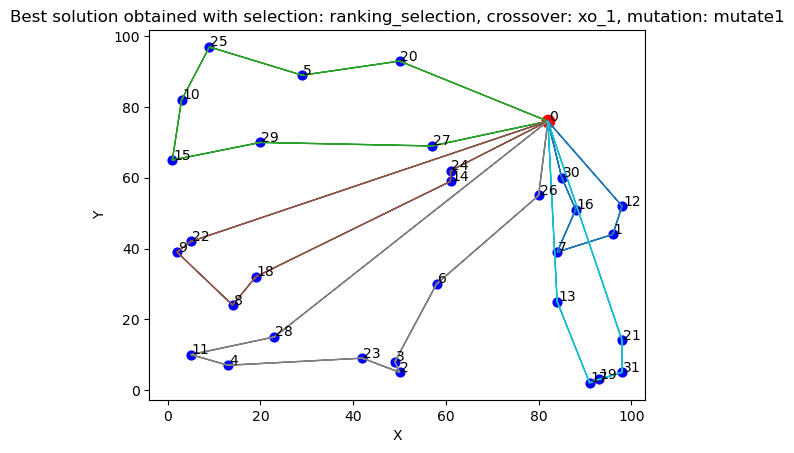

Selection algorithm: ranking_selection. Crossover Operation: xo_1. Mutation Type: mutate2
Best fitness: 900.95. Best solution: [[30, 28, 4, 29, 16, 21, 26, 31, 6, 15, 24, 2, 11, 14, 3, 8, 7, 10, 25, 13, 23, 5, 19, 9, 22, 1, 27, 20, 17, 18, 12], [1, 0, 0, 3, 1, 1, 4, 1, 4, 3, 2, 4, 0, 2, 4, 0, 2, 3, 3, 2, 4, 3, 1, 0, 0, 2, 4, 3, 1, 0, 2]].
Average fitness benchmarks: {0: inf, 100: 952.35, 200: 952.09, 300: 950.44, 400: 950.13, 500: 947.57, 600: 945.45, 700: 943.34, 800: 943.15, 900: 942.74, 1000: 942.74, 1100: 942.74, 1200: 939.97, 1300: 939.97, 1400: 939.29, 1500: 938.2, 1600: 938.2, 1700: 938.2, 1800: 938.2, 1900: 937.41, 2000: 937.41, 2100: 937.41, 2200: 937.41, 2300: 937.3, 2400: 937.3, 2500: 936.91, 2600: 935.62, 2700: 935.62, 2800: 935.6, 2900: 932.2, 3000: 932.0}


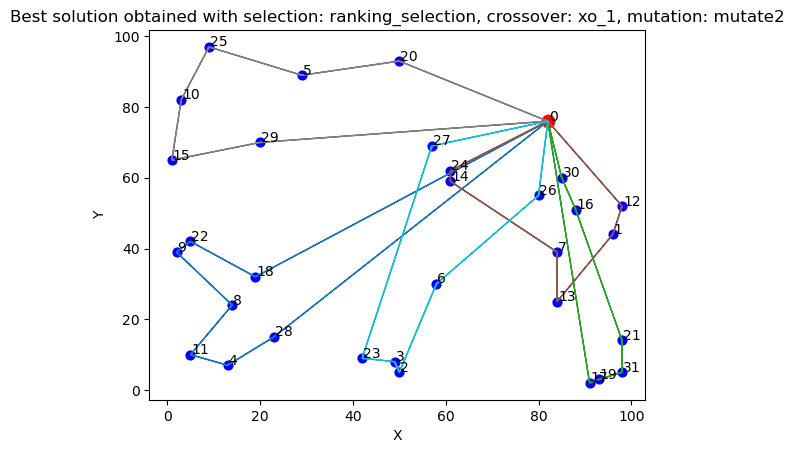

Selection algorithm: ranking_selection. Crossover Operation: xo_1. Mutation Type: mutate3
Best fitness: 880.28. Best solution: [[14, 13, 26, 7, 20, 1, 28, 24, 17, 5, 12, 4, 18, 16, 25, 8, 23, 11, 10, 9, 29, 22, 2, 19, 27, 30, 31, 21, 15, 3, 6], [0, 4, 3, 3, 1, 3, 0, 2, 4, 1, 3, 0, 2, 3, 1, 2, 2, 0, 1, 0, 1, 0, 2, 4, 1, 3, 4, 4, 0, 2, 2]].
Average fitness benchmarks: {0: inf, 100: 923.65, 200: 920.68, 300: 913.84, 400: 913.68, 500: 911.04, 600: 909.45, 700: 909.16, 800: 908.41, 900: 906.64, 1000: 906.27, 1100: 905.99, 1200: 905.89, 1300: 905.89, 1400: 904.99, 1500: 901.49, 1600: 899.77, 1700: 899.73, 1800: 899.73, 1900: 899.73, 2000: 899.46, 2100: 899.46, 2200: 899.18, 2300: 899.06, 2400: 898.93, 2500: 898.92, 2600: 898.92, 2700: 898.92, 2800: 898.92, 2900: 898.48, 3000: 898.05}


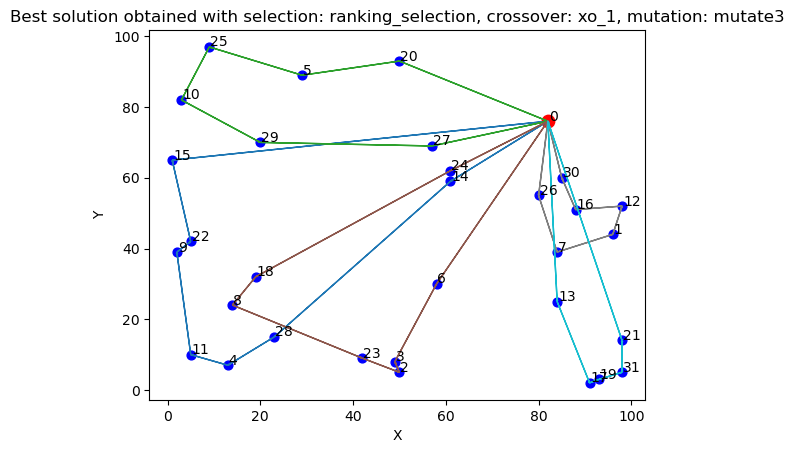

Selection algorithm: ranking_selection. Crossover Operation: xo_1. Mutation Type: mutate4
Best fitness: 887.61. Best solution: [[27, 5, 30, 26, 16, 18, 21, 25, 24, 7, 31, 10, 19, 8, 17, 15, 28, 4, 29, 13, 1, 12, 2, 20, 6, 11, 9, 14, 22, 3, 23], [2, 1, 0, 0, 0, 2, 4, 1, 3, 3, 4, 1, 4, 2, 4, 1, 2, 2, 1, 3, 0, 0, 4, 1, 3, 2, 2, 3, 2, 4, 4]].
Average fitness benchmarks: {0: inf, 100: 926.34, 200: 920.89, 300: 917.86, 400: 917.86, 500: 916.88, 600: 916.06, 700: 916.01, 800: 914.98, 900: 913.26, 1000: 913.26, 1100: 911.69, 1200: 911.59, 1300: 910.55, 1400: 909.67, 1500: 909.49, 1600: 908.42, 1700: 908.35, 1800: 908.35, 1900: 908.35, 2000: 908.35, 2100: 907.92, 2200: 907.92, 2300: 907.92, 2400: 907.92, 2500: 907.73, 2600: 907.23, 2700: 907.23, 2800: 907.16, 2900: 904.98, 3000: 904.98}


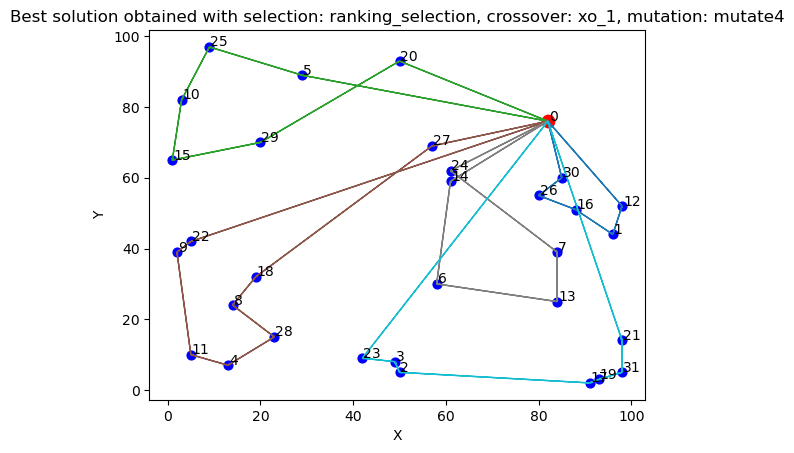

Selection algorithm: ranking_selection. Crossover Operation: xo_1. Mutation Type: mutate5
Best fitness: 901.39. Best solution: [[12, 28, 23, 2, 20, 27, 22, 7, 9, 3, 1, 16, 5, 29, 8, 4, 26, 11, 15, 13, 17, 19, 14, 31, 10, 21, 6, 25, 24, 30, 18], [3, 2, 2, 2, 0, 4, 4, 1, 4, 2, 3, 3, 0, 0, 4, 4, 3, 4, 0, 1, 1, 1, 3, 1, 0, 1, 2, 0, 3, 2, 4]].
Average fitness benchmarks: {0: inf, 100: 962.64, 200: 960.73, 300: 960.69, 400: 959.39, 500: 958.29, 600: 958.25, 700: 957.89, 800: 955.92, 900: 955.69, 1000: 955.69, 1100: 955.14, 1200: 954.25, 1300: 953.39, 1400: 953.29, 1500: 952.87, 1600: 952.87, 1700: 951.57, 1800: 951.45, 1900: 951.08, 2000: 950.71, 2100: 950.71, 2200: 950.36, 2300: 949.03, 2400: 947.29, 2500: 945.84, 2600: 945.08, 2700: 945.02, 2800: 945.02, 2900: 944.7, 3000: 944.7}


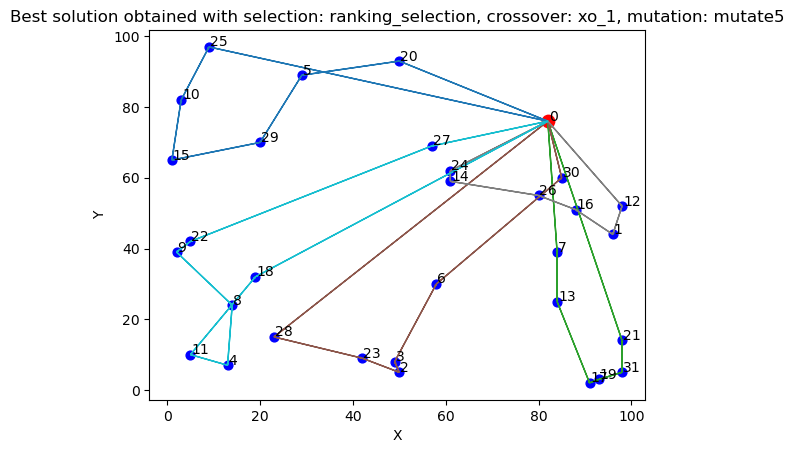

Selection algorithm: ranking_selection. Crossover Operation: xo_1. Mutation Type: mutate6
Best fitness: 867.6. Best solution: [[20, 7, 22, 28, 5, 25, 9, 13, 17, 30, 4, 26, 16, 18, 10, 11, 15, 8, 23, 19, 29, 2, 3, 31, 1, 12, 6, 14, 24, 21, 27], [3, 2, 4, 1, 3, 3, 4, 2, 2, 0, 1, 0, 0, 4, 3, 1, 3, 1, 4, 2, 3, 4, 4, 2, 0, 0, 4, 1, 1, 2, 3]].
Average fitness benchmarks: {0: inf, 100: 916.91, 200: 912.63, 300: 907.42, 400: 906.81, 500: 906.43, 600: 905.13, 700: 904.07, 800: 903.95, 900: 902.67, 1000: 902.23, 1100: 902.23, 1200: 900.53, 1300: 900.53, 1400: 900.53, 1500: 900.45, 1600: 900.38, 1700: 900.38, 1800: 899.77, 1900: 899.05, 2000: 898.6, 2100: 895.98, 2200: 894.0, 2300: 893.29, 2400: 892.94, 2500: 892.94, 2600: 892.22, 2700: 891.57, 2800: 891.45, 2900: 890.66, 3000: 890.66}


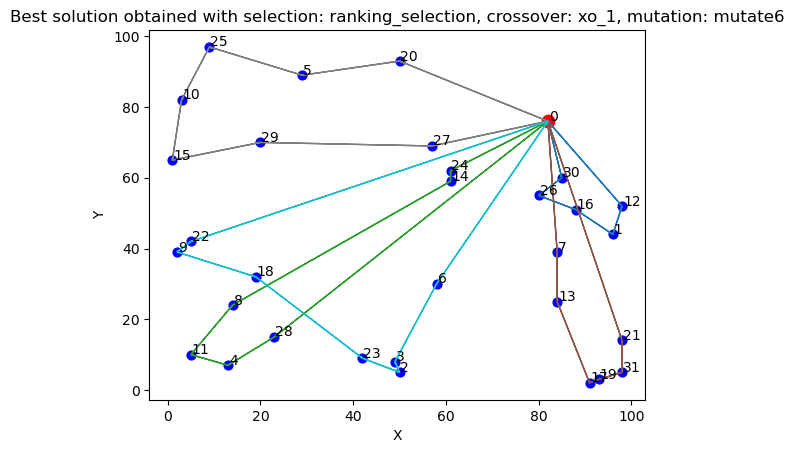

Selection algorithm: ranking_selection. Crossover Operation: xo_2. Mutation Type: mutate1
Best fitness: 851.91. Best solution: [[22, 29, 7, 21, 15, 10, 12, 24, 1, 14, 23, 25, 5, 9, 2, 8, 11, 31, 3, 19, 4, 20, 6, 16, 26, 17, 27, 30, 28, 18, 13], [1, 2, 0, 0, 2, 2, 4, 3, 4, 3, 3, 2, 2, 1, 3, 1, 1, 0, 3, 0, 1, 2, 3, 4, 3, 0, 2, 4, 1, 1, 0]].
Average fitness benchmarks: {0: inf, 100: 900.1, 200: 900.1, 300: 898.38, 400: 894.22, 500: 892.65, 600: 891.81, 700: 891.75, 800: 890.96, 900: 888.97, 1000: 888.32, 1100: 886.55, 1200: 885.75, 1300: 885.72, 1400: 885.26, 1500: 885.24, 1600: 884.92, 1700: 884.27, 1800: 883.52, 1900: 882.24, 2000: 882.0, 2100: 881.34, 2200: 881.34, 2300: 881.34, 2400: 881.34, 2500: 880.5, 2600: 880.37, 2700: 879.98, 2800: 879.25, 2900: 879.25, 3000: 879.21}


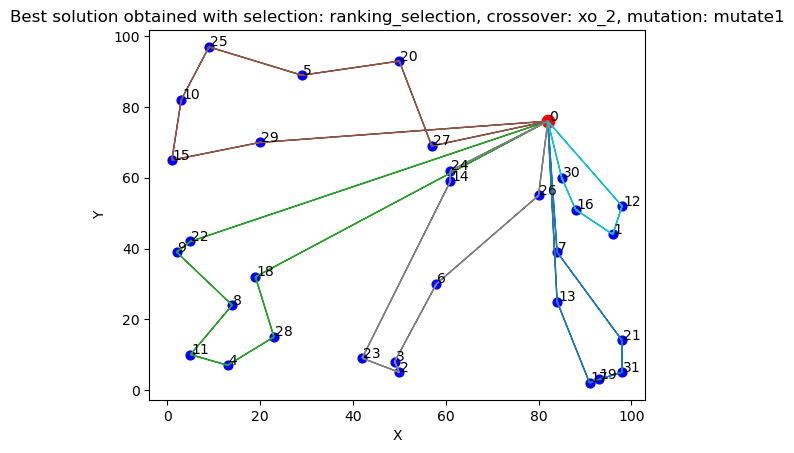

Selection algorithm: ranking_selection. Crossover Operation: xo_2. Mutation Type: mutate2
Best fitness: 874.52. Best solution: [[14, 24, 27, 13, 23, 18, 8, 9, 29, 30, 28, 22, 11, 26, 17, 4, 16, 19, 2, 15, 31, 5, 21, 7, 1, 10, 3, 6, 12, 20, 25], [3, 3, 3, 2, 1, 4, 4, 4, 3, 0, 1, 4, 1, 0, 2, 1, 0, 2, 1, 4, 2, 3, 2, 2, 0, 4, 1, 1, 0, 3, 4]].
Average fitness benchmarks: {0: inf, 100: 988.4, 200: 986.74, 300: 981.55, 400: 980.15, 500: 978.82, 600: 978.4, 700: 976.36, 800: 974.54, 900: 974.54, 1000: 973.63, 1100: 973.12, 1200: 973.02, 1300: 973.02, 1400: 972.09, 1500: 971.8, 1600: 969.63, 1700: 969.62, 1800: 969.52, 1900: 969.03, 2000: 969.03, 2100: 967.8, 2200: 966.24, 2300: 966.12, 2400: 965.23, 2500: 964.96, 2600: 964.96, 2700: 964.96, 2800: 964.96, 2900: 964.65, 3000: 964.6}


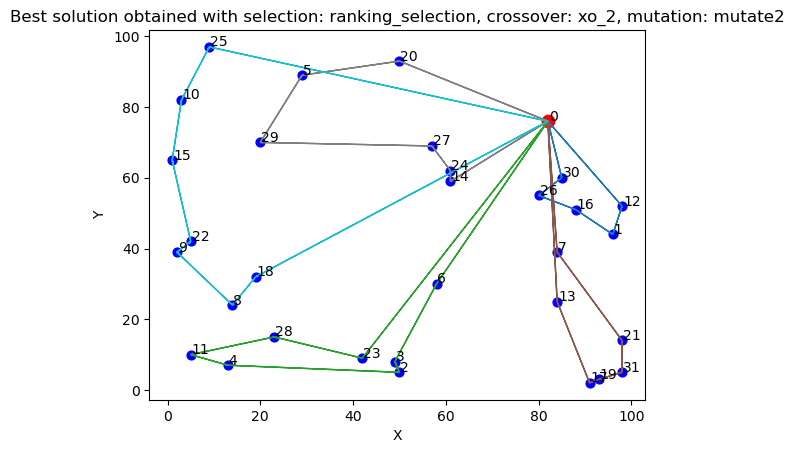

Selection algorithm: ranking_selection. Crossover Operation: xo_2. Mutation Type: mutate3
Best fitness: 933.66. Best solution: [[12, 1, 23, 28, 3, 4, 11, 10, 25, 29, 15, 5, 8, 20, 27, 2, 16, 22, 17, 30, 24, 19, 18, 14, 9, 31, 6, 21, 13, 7, 26], [1, 1, 2, 4, 2, 4, 4, 3, 3, 0, 0, 3, 4, 3, 3, 2, 1, 0, 2, 1, 3, 2, 4, 4, 0, 2, 0, 2, 0, 0, 0]].
Average fitness benchmarks: {0: inf, 100: 982.1, 200: 980.03, 300: 976.56, 400: 975.8, 500: 969.52, 600: 968.73, 700: 965.37, 800: 965.37, 900: 963.37, 1000: 963.37, 1100: 963.37, 1200: 963.35, 1300: 963.27, 1400: 963.27, 1500: 962.63, 1600: 962.63, 1700: 962.4, 1800: 962.26, 1900: 962.26, 2000: 961.68, 2100: 961.51, 2200: 961.08, 2300: 960.96, 2400: 960.96, 2500: 960.96, 2600: 960.88, 2700: 960.88, 2800: 960.88, 2900: 959.91, 3000: 959.91}


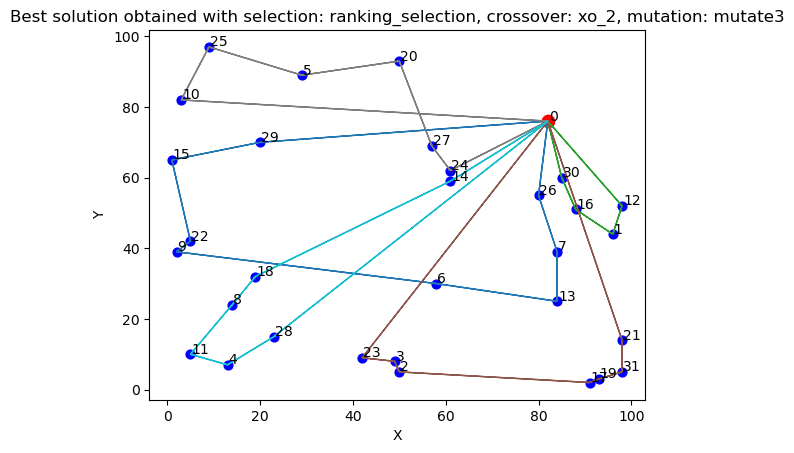

Selection algorithm: ranking_selection. Crossover Operation: xo_2. Mutation Type: mutate4
Best fitness: 928.52. Best solution: [[24, 21, 27, 12, 14, 22, 31, 9, 28, 4, 1, 23, 11, 2, 3, 15, 19, 29, 17, 16, 30, 10, 20, 13, 8, 7, 25, 5, 18, 6, 26], [0, 4, 2, 3, 0, 1, 4, 1, 2, 2, 3, 0, 2, 0, 0, 1, 4, 1, 4, 3, 3, 1, 3, 4, 2, 4, 1, 1, 2, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 979.77, 200: 979.66, 300: 979.03, 400: 975.43, 500: 973.72, 600: 972.22, 700: 970.06, 800: 969.25, 900: 967.33, 1000: 967.0, 1100: 965.88, 1200: 965.12, 1300: 964.61, 1400: 964.61, 1500: 963.18, 1600: 963.05, 1700: 962.73, 1800: 962.73, 1900: 961.99, 2000: 961.99, 2100: 961.51, 2200: 960.9, 2300: 960.9, 2400: 960.89, 2500: 960.77, 2600: 960.56, 2700: 960.54, 2800: 960.4, 2900: 958.15, 3000: 958.15}


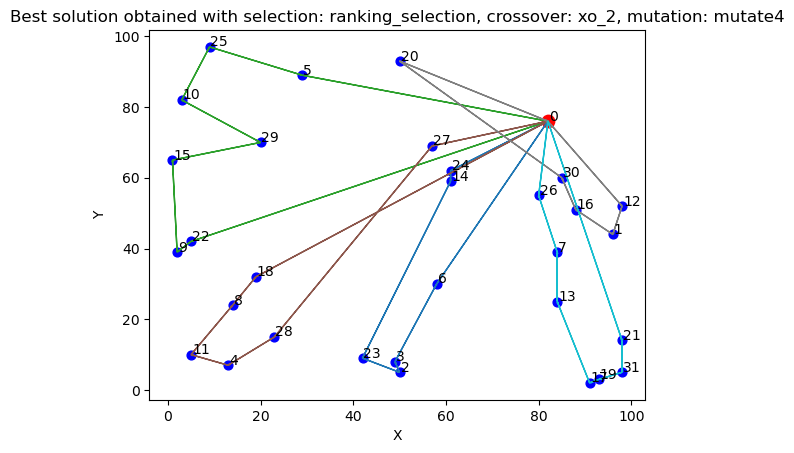

Selection algorithm: ranking_selection. Crossover Operation: xo_2. Mutation Type: mutate5
Best fitness: 868.31. Best solution: [[30, 27, 20, 26, 6, 24, 13, 3, 5, 25, 16, 7, 17, 19, 28, 4, 10, 2, 15, 9, 31, 1, 21, 11, 8, 23, 12, 22, 29, 14, 18], [0, 1, 2, 4, 3, 1, 4, 3, 2, 2, 0, 0, 4, 4, 1, 1, 2, 3, 2, 2, 4, 0, 4, 1, 1, 3, 0, 2, 2, 3, 1]].
Average fitness benchmarks: {0: inf, 100: 912.9, 200: 907.93, 300: 906.95, 400: 901.89, 500: 898.82, 600: 898.61, 700: 898.37, 800: 897.1, 900: 896.66, 1000: 896.64, 1100: 895.38, 1200: 895.28, 1300: 895.28, 1400: 895.11, 1500: 894.9, 1600: 894.9, 1700: 893.49, 1800: 892.42, 1900: 892.19, 2000: 891.76, 2100: 891.55, 2200: 890.99, 2300: 890.99, 2400: 890.47, 2500: 890.28, 2600: 889.98, 2700: 889.91, 2800: 889.12, 2900: 888.91, 3000: 887.81}


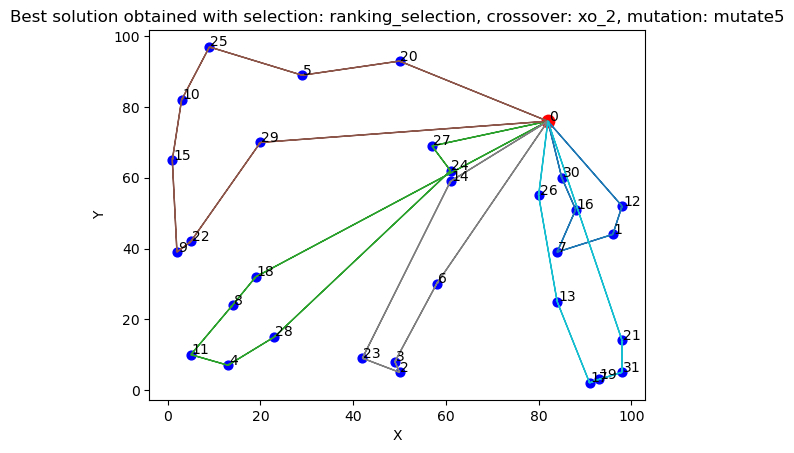

Selection algorithm: ranking_selection. Crossover Operation: xo_2. Mutation Type: mutate6
Best fitness: 913.64. Best solution: [[9, 7, 6, 20, 11, 29, 27, 13, 24, 26, 16, 14, 18, 1, 4, 28, 23, 17, 2, 8, 22, 12, 30, 19, 15, 10, 3, 25, 31, 21, 5], [0, 3, 3, 1, 0, 1, 2, 1, 2, 4, 4, 2, 3, 4, 0, 0, 0, 1, 0, 3, 3, 4, 4, 1, 3, 3, 0, 3, 1, 1, 3]].
Average fitness benchmarks: {0: inf, 100: 975.66, 200: 973.95, 300: 970.6, 400: 970.39, 500: 970.39, 600: 969.07, 700: 968.82, 800: 968.12, 900: 966.71, 1000: 965.94, 1100: 965.87, 1200: 964.87, 1300: 964.87, 1400: 963.82, 1500: 962.42, 1600: 961.13, 1700: 960.9, 1800: 960.9, 1900: 960.9, 2000: 959.18, 2100: 958.56, 2200: 958.56, 2300: 958.56, 2400: 958.38, 2500: 957.42, 2600: 957.34, 2700: 957.17, 2800: 957.17, 2900: 957.17, 3000: 957.17}


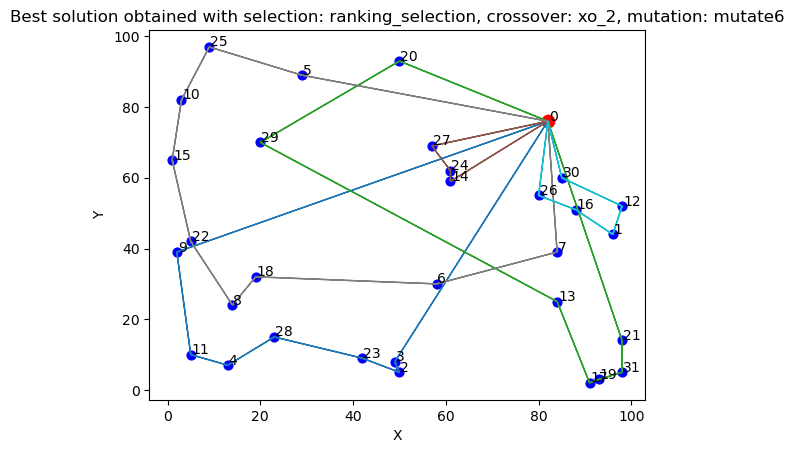

Selection algorithm: ranking_selection. Crossover Operation: xo_3. Mutation Type: mutate1
Best fitness: 877.82. Best solution: [[19, 17, 30, 20, 16, 24, 5, 27, 12, 25, 2, 10, 15, 22, 3, 14, 9, 23, 18, 8, 29, 11, 7, 6, 13, 26, 4, 31, 28, 21, 1], [4, 4, 0, 1, 0, 2, 1, 3, 0, 1, 4, 1, 1, 3, 4, 2, 3, 4, 3, 3, 1, 3, 2, 4, 2, 4, 3, 2, 3, 2, 2]].
Average fitness benchmarks: {0: inf, 100: 886.37, 200: 880.9, 300: 879.08, 400: 879.08, 500: 878.58, 600: 878.58, 700: 878.58, 800: 878.55, 900: 878.27, 1000: 878.06, 1100: 878.06, 1200: 878.06, 1300: 878.06, 1400: 878.02, 1500: 877.93, 1600: 877.82, 1700: 877.82, 1800: 877.82, 1900: 877.82, 2000: 877.82, 2100: 877.82, 2200: 877.82, 2300: 877.82, 2400: 877.82, 2500: 877.82, 2600: 877.82, 2700: 877.82, 2800: 877.82, 2900: 877.82, 3000: 877.82}


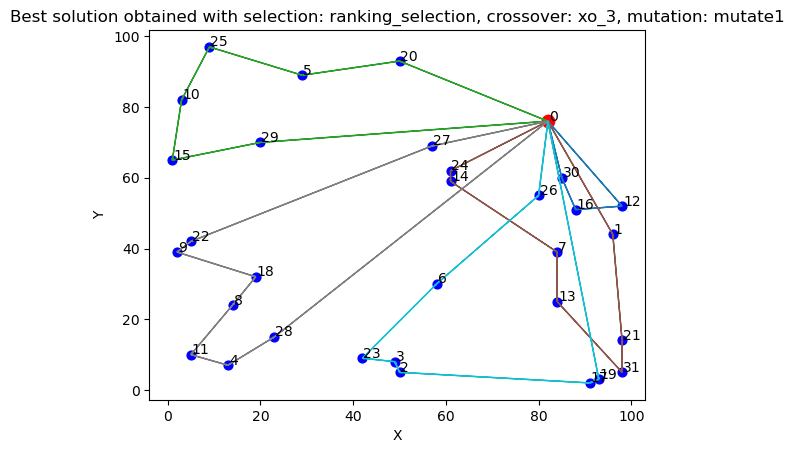

Selection algorithm: ranking_selection. Crossover Operation: xo_3. Mutation Type: mutate2
Best fitness: 906.78. Best solution: [[30, 20, 18, 7, 13, 8, 28, 23, 29, 3, 15, 22, 5, 25, 2, 16, 9, 17, 10, 26, 14, 11, 31, 4, 6, 24, 21, 1, 27, 12, 19], [2, 1, 3, 0, 0, 3, 3, 3, 4, 3, 4, 4, 1, 1, 3, 2, 4, 3, 1, 2, 2, 4, 0, 4, 4, 2, 0, 0, 1, 0, 3]].
Average fitness benchmarks: {0: inf, 100: 938.24, 200: 933.5, 300: 931.74, 400: 931.45, 500: 931.29, 600: 931.29, 700: 931.06, 800: 931.06, 900: 931.06, 1000: 931.06, 1100: 931.06, 1200: 930.94, 1300: 930.94, 1400: 930.94, 1500: 930.94, 1600: 929.8, 1700: 929.8, 1800: 929.8, 1900: 929.8, 2000: 929.8, 2100: 929.8, 2200: 929.8, 2300: 929.8, 2400: 929.8, 2500: 929.8, 2600: 929.8, 2700: 929.8, 2800: 929.8, 2900: 929.8, 3000: 928.33}


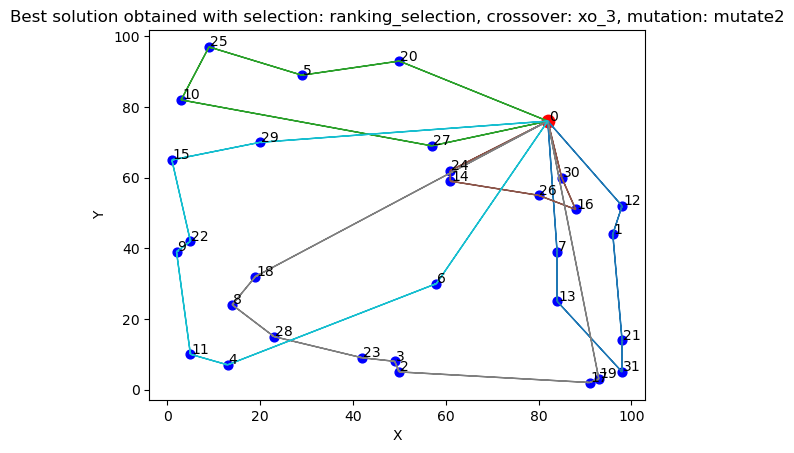

Selection algorithm: ranking_selection. Crossover Operation: xo_3. Mutation Type: mutate3
Best fitness: 883.95. Best solution: [[27, 7, 9, 30, 21, 16, 6, 2, 18, 12, 28, 4, 20, 11, 5, 3, 10, 23, 8, 31, 1, 19, 17, 22, 13, 14, 26, 15, 29, 24, 25], [0, 3, 2, 4, 3, 4, 0, 0, 2, 4, 2, 2, 1, 2, 1, 0, 1, 0, 2, 3, 4, 3, 3, 2, 3, 0, 3, 2, 2, 0, 1]].
Average fitness benchmarks: {0: inf, 100: 909.12, 200: 905.7, 300: 898.66, 400: 898.48, 500: 898.32, 600: 898.32, 700: 897.0, 800: 897.0, 900: 897.0, 1000: 897.0, 1100: 896.5, 1200: 896.5, 1300: 896.5, 1400: 896.5, 1500: 896.5, 1600: 895.93, 1700: 895.45, 1800: 895.45, 1900: 895.45, 2000: 894.89, 2100: 894.89, 2200: 894.89, 2300: 894.37, 2400: 894.14, 2500: 894.14, 2600: 894.14, 2700: 894.14, 2800: 893.85, 2900: 893.8, 3000: 893.8}


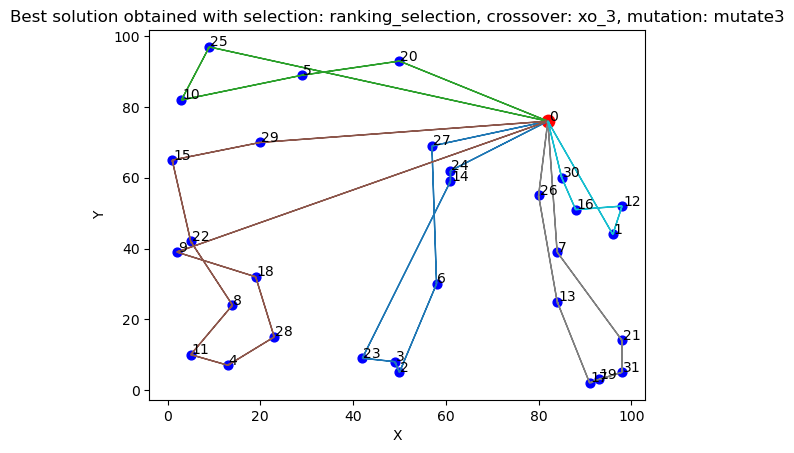

Selection algorithm: ranking_selection. Crossover Operation: xo_3. Mutation Type: mutate4
Best fitness: 988.19. Best solution: [[16, 18, 31, 9, 6, 30, 3, 29, 19, 2, 26, 10, 17, 21, 13, 14, 27, 15, 22, 7, 8, 11, 4, 1, 12, 28, 23, 24, 20, 5, 25], [2, 4, 2, 4, 0, 1, 0, 4, 2, 0, 1, 3, 2, 2, 0, 1, 1, 3, 3, 2, 3, 3, 3, 0, 0, 3, 3, 1, 4, 4, 4]].
Average fitness benchmarks: {0: inf, 100: 1027.81, 200: 1025.62, 300: 1025.04, 400: 1023.1, 500: 1022.62, 600: 1021.96, 700: 1021.96, 800: 1021.96, 900: 1021.96, 1000: 1021.96, 1100: 1021.96, 1200: 1021.96, 1300: 1021.96, 1400: 1021.96, 1500: 1021.96, 1600: 1019.06, 1700: 1019.06, 1800: 1019.06, 1900: 1018.72, 2000: 1018.64, 2100: 1018.64, 2200: 1018.57, 2300: 1018.57, 2400: 1018.57, 2500: 1018.57, 2600: 1018.46, 2700: 1018.46, 2800: 1018.46, 2900: 1018.46, 3000: 1018.33}


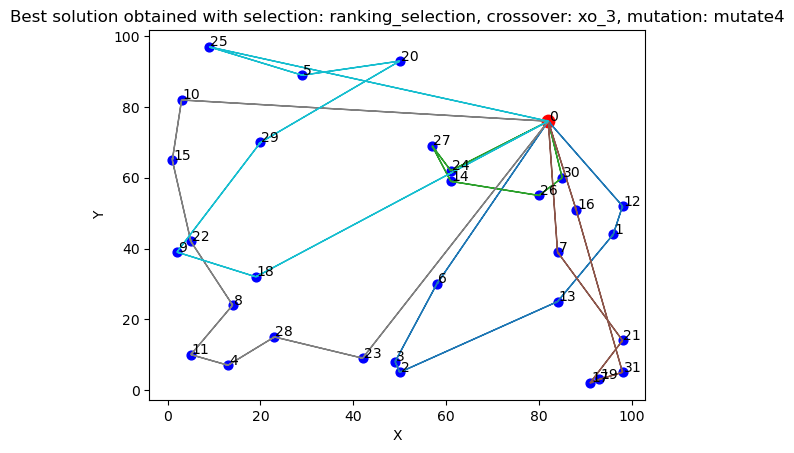

Selection algorithm: ranking_selection. Crossover Operation: xo_3. Mutation Type: mutate5
Best fitness: 945.5. Best solution: [[24, 20, 22, 12, 5, 21, 30, 1, 26, 9, 31, 7, 19, 25, 14, 17, 15, 18, 8, 13, 11, 4, 2, 10, 28, 27, 3, 29, 6, 23, 16], [1, 3, 1, 4, 3, 2, 0, 4, 0, 1, 2, 4, 2, 3, 0, 2, 1, 0, 0, 2, 0, 0, 4, 3, 0, 3, 4, 1, 4, 0, 2]].
Average fitness benchmarks: {0: inf, 100: 957.73, 200: 948.0, 300: 946.36, 400: 946.04, 500: 945.5, 600: 945.5, 700: 945.5, 800: 945.5, 900: 945.5, 1000: 945.5, 1100: 945.5, 1200: 945.5, 1300: 945.5, 1400: 945.5, 1500: 945.5, 1600: 945.5, 1700: 945.5, 1800: 945.5, 1900: 945.5, 2000: 945.5, 2100: 945.5, 2200: 945.5, 2300: 945.5, 2400: 945.5, 2500: 945.5, 2600: 945.5, 2700: 945.5, 2800: 945.5, 2900: 945.5, 3000: 945.5}


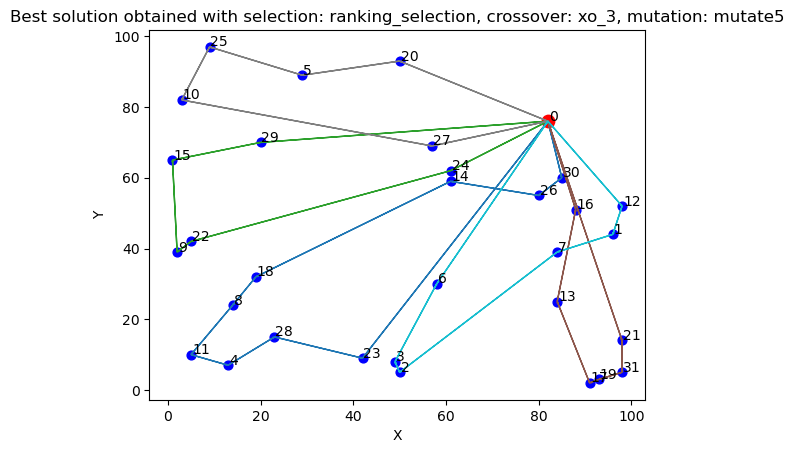

Selection algorithm: ranking_selection. Crossover Operation: xo_3. Mutation Type: mutate6
Best fitness: 896.6. Best solution: [[21, 26, 7, 31, 19, 6, 20, 30, 17, 13, 3, 2, 29, 23, 4, 14, 11, 9, 24, 28, 27, 16, 15, 10, 22, 25, 1, 12, 8, 5, 18], [1, 2, 2, 1, 1, 3, 4, 0, 1, 2, 1, 3, 4, 1, 3, 2, 3, 3, 2, 1, 2, 0, 4, 4, 3, 4, 0, 0, 1, 4, 1]].
Average fitness benchmarks: {0: inf, 100: 914.74, 200: 910.97, 300: 909.04, 400: 906.88, 500: 905.88, 600: 904.06, 700: 903.1, 800: 902.42, 900: 901.13, 1000: 901.13, 1100: 901.12, 1200: 901.12, 1300: 901.12, 1400: 901.12, 1500: 901.12, 1600: 900.77, 1700: 900.77, 1800: 900.77, 1900: 900.77, 2000: 900.77, 2100: 900.75, 2200: 900.59, 2300: 900.59, 2400: 900.59, 2500: 900.59, 2600: 899.98, 2700: 899.98, 2800: 899.98, 2900: 899.98, 3000: 899.98}


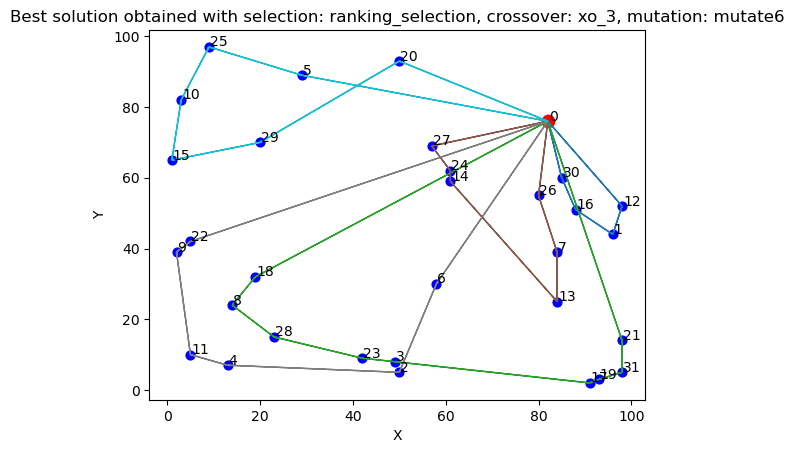

Selection algorithm: ranking_selection. Crossover Operation: xo_4. Mutation Type: mutate1
Best fitness: 835.7. Best solution: [[24, 30, 14, 23, 2, 20, 16, 27, 21, 1, 3, 31, 18, 12, 19, 28, 5, 25, 4, 17, 11, 10, 13, 15, 7, 6, 8, 9, 29, 26, 22], [0, 4, 0, 0, 0, 1, 4, 3, 2, 4, 0, 2, 3, 4, 2, 3, 1, 1, 3, 2, 3, 1, 2, 1, 2, 0, 3, 3, 1, 2, 3]].
Average fitness benchmarks: {0: inf, 100: 842.92, 200: 839.68, 300: 836.68, 400: 836.04, 500: 835.95, 600: 835.95, 700: 835.95, 800: 835.95, 900: 835.95, 1000: 835.95, 1100: 835.95, 1200: 835.85, 1300: 835.7, 1400: 835.7, 1500: 835.7, 1600: 835.7, 1700: 835.7, 1800: 835.7, 1900: 835.7, 2000: 835.7, 2100: 835.7, 2200: 835.7, 2300: 835.7, 2400: 835.7, 2500: 835.7, 2600: 835.7, 2700: 835.7, 2800: 835.7, 2900: 835.7, 3000: 835.7}


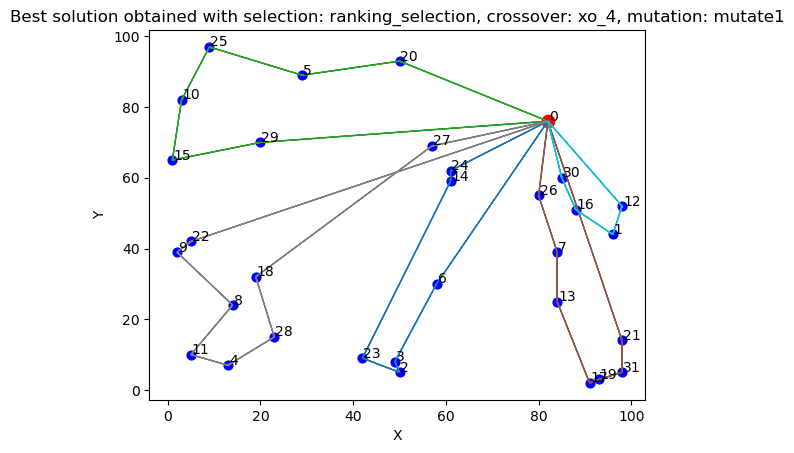

Selection algorithm: ranking_selection. Crossover Operation: xo_4. Mutation Type: mutate2
Best fitness: 939.88. Best solution: [[17, 24, 30, 23, 14, 10, 22, 19, 26, 28, 9, 4, 31, 25, 6, 3, 2, 13, 5, 21, 15, 20, 7, 29, 1, 11, 8, 16, 12, 18, 27], [3, 0, 4, 4, 0, 2, 0, 3, 1, 4, 0, 4, 3, 2, 1, 1, 1, 1, 2, 3, 0, 2, 3, 0, 1, 4, 4, 3, 1, 4, 0]].
Average fitness benchmarks: {0: inf, 100: 948.61, 200: 947.09, 300: 945.8, 400: 943.59, 500: 942.69, 600: 942.51, 700: 942.47, 800: 942.47, 900: 942.02, 1000: 941.99, 1100: 941.92, 1200: 941.92, 1300: 941.92, 1400: 941.92, 1500: 941.92, 1600: 941.92, 1700: 941.92, 1800: 941.92, 1900: 941.92, 2000: 941.92, 2100: 941.92, 2200: 941.92, 2300: 941.92, 2400: 941.92, 2500: 941.92, 2600: 941.92, 2700: 941.92, 2800: 941.92, 2900: 941.92, 3000: 941.92}


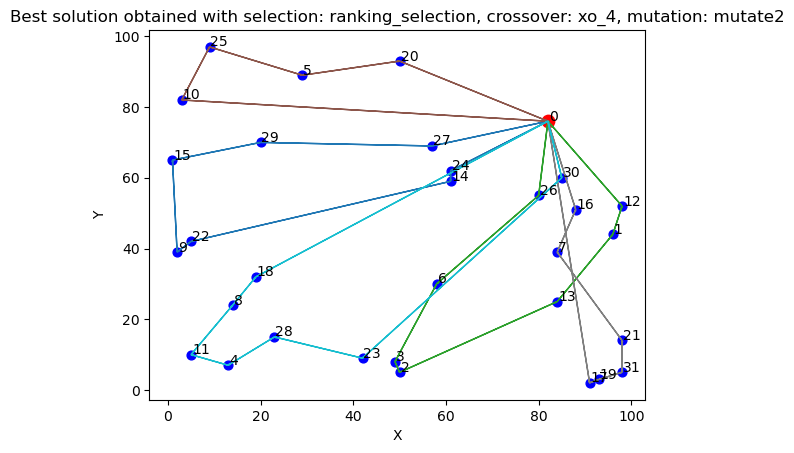

Selection algorithm: ranking_selection. Crossover Operation: xo_4. Mutation Type: mutate3
Best fitness: 894.4. Best solution: [[1, 28, 4, 19, 20, 24, 11, 12, 8, 9, 22, 13, 6, 23, 29, 18, 17, 15, 2, 10, 14, 16, 26, 30, 31, 25, 3, 21, 27, 7, 5], [4, 0, 0, 4, 1, 3, 0, 2, 0, 0, 0, 3, 3, 3, 1, 0, 4, 1, 3, 1, 0, 2, 2, 2, 4, 1, 3, 4, 0, 4, 1]].
Average fitness benchmarks: {0: inf, 100: 932.32, 200: 929.75, 300: 929.44, 400: 929.44, 500: 928.83, 600: 928.83, 700: 925.97, 800: 925.63, 900: 925.63, 1000: 925.63, 1100: 925.63, 1200: 922.52, 1300: 921.71, 1400: 921.71, 1500: 921.71, 1600: 921.64, 1700: 921.64, 1800: 921.64, 1900: 921.64, 2000: 921.64, 2100: 921.64, 2200: 921.64, 2300: 921.64, 2400: 921.05, 2500: 920.57, 2600: 920.57, 2700: 920.22, 2800: 920.22, 2900: 920.22, 3000: 920.22}


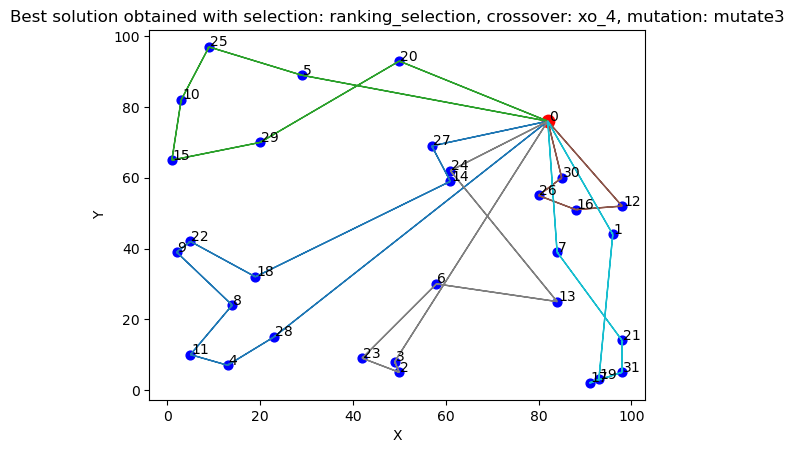

Selection algorithm: ranking_selection. Crossover Operation: xo_4. Mutation Type: mutate4
Best fitness: 994.54. Best solution: [[24, 7, 26, 22, 9, 18, 20, 29, 15, 10, 8, 3, 17, 13, 2, 30, 21, 5, 23, 6, 4, 12, 11, 31, 28, 14, 25, 27, 1, 19, 16], [3, 3, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 1, 1, 4, 0, 2, 1, 3, 1, 4, 1, 0, 1, 1, 2, 2, 4, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 1004.12, 200: 1002.75, 300: 1002.75, 400: 1002.39, 500: 1000.27, 600: 1000.04, 700: 1000.04, 800: 1000.04, 900: 1000.04, 1000: 1000.04, 1100: 1000.04, 1200: 1000.03, 1300: 999.99, 1400: 999.99, 1500: 999.99, 1600: 999.99, 1700: 999.99, 1800: 999.99, 1900: 999.93, 2000: 999.86, 2100: 999.86, 2200: 999.86, 2300: 999.86, 2400: 999.72, 2500: 999.72, 2600: 999.54, 2700: 999.54, 2800: 999.54, 2900: 999.54, 3000: 999.54}


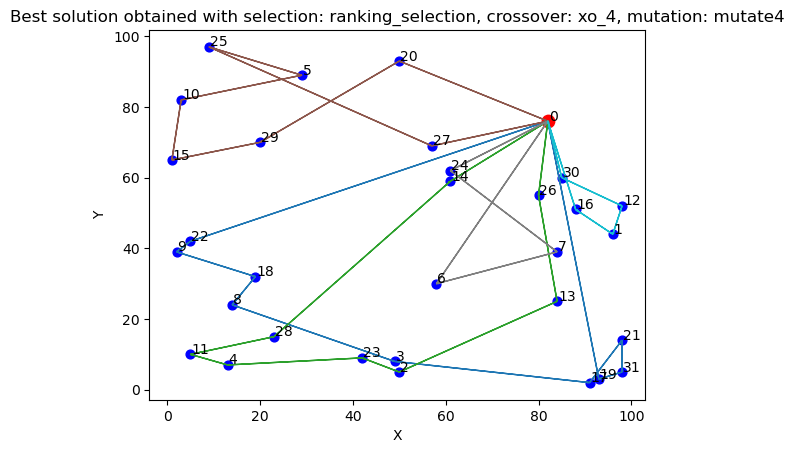

Selection algorithm: ranking_selection. Crossover Operation: xo_4. Mutation Type: mutate5
Best fitness: 867.43. Best solution: [[14, 18, 27, 9, 22, 8, 30, 11, 4, 7, 13, 28, 17, 16, 19, 6, 3, 31, 2, 15, 29, 1, 21, 23, 10, 25, 24, 12, 5, 26, 20], [3, 3, 1, 3, 3, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 4, 4, 0, 4, 3, 3, 2, 0, 4, 3, 3, 1, 2, 3, 0, 3]].
Average fitness benchmarks: {0: inf, 100: 875.9, 200: 872.16, 300: 868.53, 400: 867.61, 500: 867.54, 600: 867.45, 700: 867.45, 800: 867.44, 900: 867.43, 1000: 867.43, 1100: 867.43, 1200: 867.43, 1300: 867.43, 1400: 867.43, 1500: 867.43, 1600: 867.43, 1700: 867.43, 1800: 867.43, 1900: 867.43, 2000: 867.43, 2100: 867.43, 2200: 867.43, 2300: 867.43, 2400: 867.43, 2500: 867.43, 2600: 867.43, 2700: 867.43, 2800: 867.43, 2900: 867.43, 3000: 867.43}


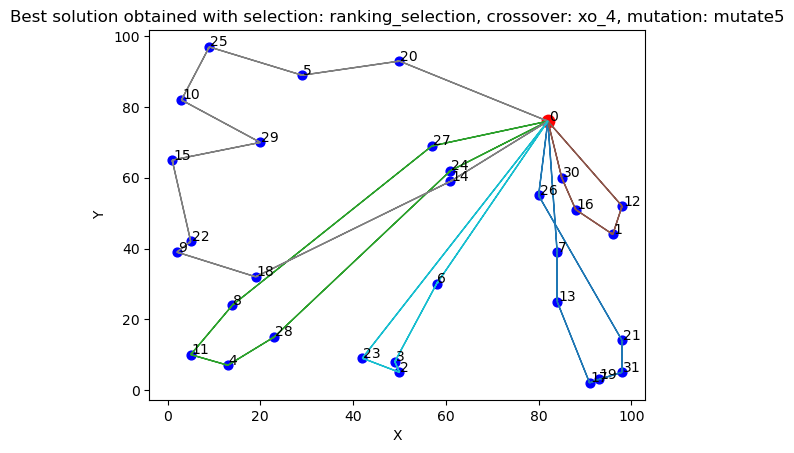

Selection algorithm: ranking_selection. Crossover Operation: xo_4. Mutation Type: mutate6
Best fitness: 867.55. Best solution: [[20, 5, 12, 27, 24, 1, 18, 31, 19, 17, 8, 30, 25, 21, 10, 16, 13, 29, 15, 9, 2, 11, 22, 3, 7, 14, 4, 23, 26, 6, 28], [2, 2, 4, 0, 0, 4, 0, 1, 1, 1, 0, 3, 2, 4, 2, 3, 4, 2, 2, 2, 1, 0, 2, 1, 4, 2, 0, 1, 4, 1, 0]].
Average fitness benchmarks: {0: inf, 100: 909.58, 200: 907.18, 300: 906.31, 400: 902.97, 500: 902.86, 600: 902.74, 700: 902.53, 800: 902.53, 900: 902.53, 1000: 902.53, 1100: 902.4, 1200: 902.4, 1300: 902.35, 1400: 901.69, 1500: 901.69, 1600: 901.25, 1700: 901.22, 1800: 901.22, 1900: 901.19, 2000: 901.19, 2100: 901.19, 2200: 901.19, 2300: 901.19, 2400: 901.16, 2500: 901.16, 2600: 901.1, 2700: 901.1, 2800: 901.07, 2900: 901.07, 3000: 900.49}


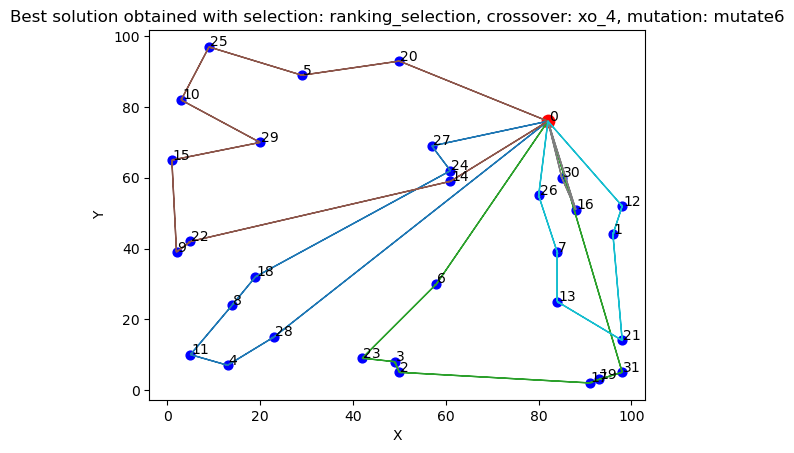

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_1. Mutation Type: mutate1
Best fitness: 848.94. Best solution: [[7, 6, 29, 15, 13, 24, 10, 3, 17, 18, 19, 30, 25, 2, 23, 31, 8, 5, 4, 16, 1, 21, 11, 28, 14, 9, 22, 26, 12, 20, 27], [3, 1, 0, 0, 3, 4, 0, 1, 3, 4, 3, 2, 0, 1, 1, 3, 4, 0, 1, 2, 2, 3, 1, 1, 1, 4, 4, 3, 2, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 867.79, 200: 864.34, 300: 858.61, 400: 857.75, 500: 854.84, 600: 854.59, 700: 853.65, 800: 852.73, 900: 852.69, 1000: 852.27, 1100: 852.27, 1200: 851.83, 1300: 851.78, 1400: 851.78, 1500: 851.78, 1600: 851.78, 1700: 851.78, 1800: 851.78, 1900: 851.78, 2000: 851.78, 2100: 851.78, 2200: 851.78, 2300: 851.78, 2400: 851.78, 2500: 851.78, 2600: 851.78, 2700: 851.78, 2800: 851.57, 2900: 851.57, 3000: 851.57}


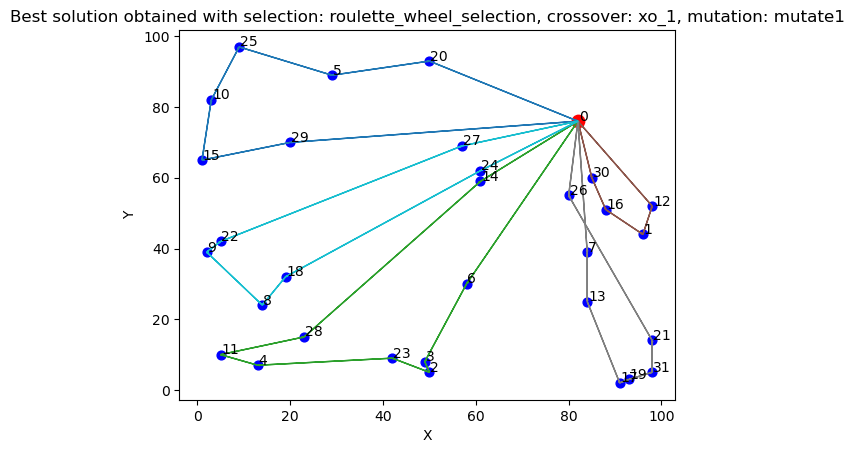

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_1. Mutation Type: mutate2
Best fitness: 836.8. Best solution: [[30, 24, 21, 6, 23, 28, 27, 4, 31, 20, 11, 16, 7, 13, 8, 5, 19, 17, 2, 25, 3, 1, 10, 18, 26, 15, 9, 29, 22, 14, 12], [4, 4, 1, 0, 0, 0, 4, 0, 1, 2, 0, 3, 3, 3, 0, 2, 1, 1, 1, 2, 1, 3, 2, 0, 1, 2, 0, 2, 0, 0, 3]].
Average fitness benchmarks: {0: inf, 100: 870.75, 200: 863.8, 300: 863.51, 400: 863.11, 500: 862.04, 600: 861.9, 700: 861.6, 800: 860.78, 900: 860.59, 1000: 860.4, 1100: 860.06, 1200: 860.05, 1300: 859.59, 1400: 859.24, 1500: 859.05, 1600: 859.05, 1700: 858.82, 1800: 857.81, 1900: 857.57, 2000: 856.2, 2100: 856.2, 2200: 856.1, 2300: 856.1, 2400: 856.1, 2500: 856.1, 2600: 856.03, 2700: 856.03, 2800: 856.03, 2900: 856.03, 3000: 856.03}


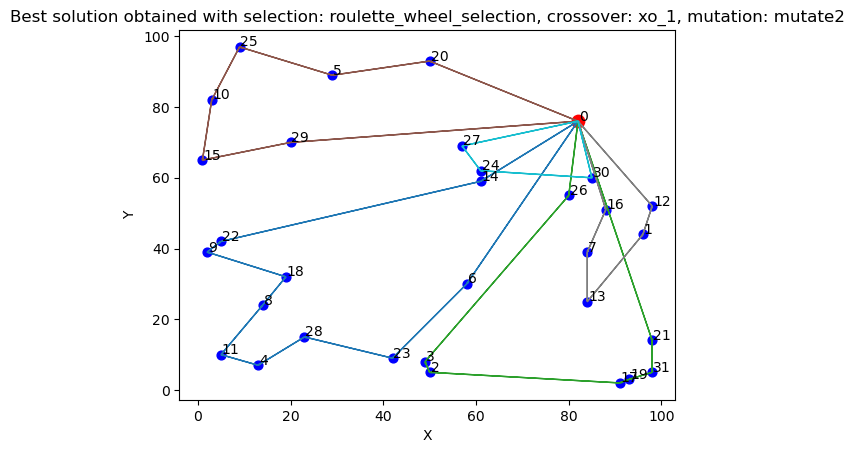

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_1. Mutation Type: mutate3
Best fitness: 835.87. Best solution: [[7, 13, 14, 28, 26, 3, 4, 24, 30, 17, 29, 11, 16, 2, 1, 15, 8, 10, 25, 23, 18, 9, 19, 6, 12, 5, 20, 31, 21, 22, 27], [4, 4, 1, 1, 2, 2, 1, 3, 0, 4, 3, 1, 0, 2, 0, 3, 1, 3, 3, 2, 1, 1, 4, 2, 0, 3, 3, 4, 4, 1, 1]].
Average fitness benchmarks: {0: inf, 100: 969.63, 200: 964.22, 300: 962.24, 400: 961.66, 500: 960.98, 600: 959.9, 700: 959.63, 800: 959.28, 900: 959.22, 1000: 959.22, 1100: 959.13, 1200: 959.13, 1300: 959.06, 1400: 959.06, 1500: 959.06, 1600: 958.95, 1700: 958.09, 1800: 957.84, 1900: 957.4, 2000: 957.19, 2100: 957.1, 2200: 957.09, 2300: 956.93, 2400: 956.78, 2500: 956.09, 2600: 955.12, 2700: 954.82, 2800: 954.3, 2900: 954.3, 3000: 954.17}


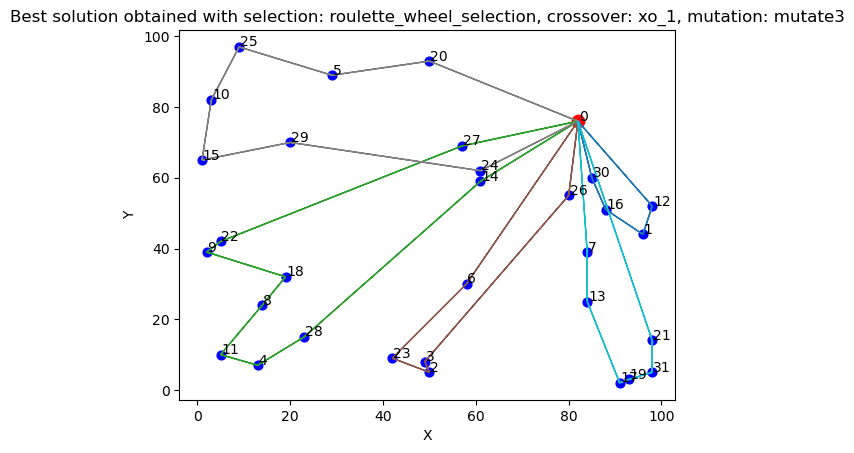

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_1. Mutation Type: mutate4
Best fitness: 801.85. Best solution: [[27, 6, 26, 20, 3, 24, 13, 14, 29, 18, 2, 23, 17, 4, 12, 11, 1, 8, 16, 28, 19, 9, 22, 31, 15, 10, 21, 30, 25, 7, 5], [4, 3, 2, 1, 3, 4, 2, 4, 1, 1, 3, 3, 2, 3, 0, 3, 0, 1, 0, 3, 2, 1, 1, 2, 1, 1, 2, 0, 1, 2, 1]].
Average fitness benchmarks: {0: inf, 100: 821.45, 200: 819.05, 300: 817.66, 400: 814.5, 500: 812.66, 600: 812.39, 700: 811.56, 800: 810.64, 900: 809.17, 1000: 808.57, 1100: 808.57, 1200: 808.27, 1300: 807.95, 1400: 807.95, 1500: 807.23, 1600: 807.23, 1700: 807.23, 1800: 807.05, 1900: 807.05, 2000: 807.01, 2100: 807.01, 2200: 807.01, 2300: 807.01, 2400: 807.01, 2500: 806.05, 2600: 805.92, 2700: 805.77, 2800: 805.77, 2900: 805.77, 3000: 805.77}


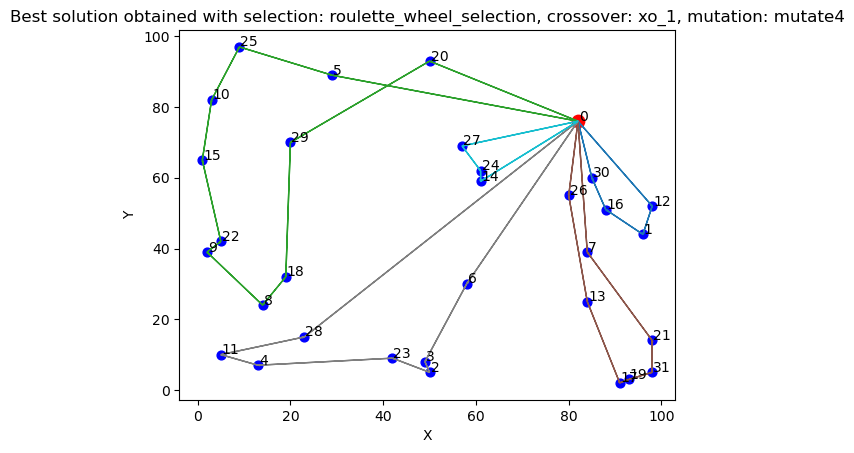

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_1. Mutation Type: mutate5
Best fitness: 832.85. Best solution: [[27, 6, 3, 26, 29, 30, 18, 8, 28, 16, 21, 15, 2, 31, 19, 4, 11, 10, 1, 17, 12, 9, 23, 13, 7, 25, 5, 14, 22, 24, 20], [2, 0, 0, 4, 2, 1, 3, 3, 3, 1, 4, 2, 0, 4, 4, 3, 3, 2, 1, 4, 1, 3, 0, 4, 4, 2, 2, 0, 3, 3, 2]].
Average fitness benchmarks: {0: inf, 100: 856.84, 200: 855.93, 300: 851.86, 400: 851.55, 500: 850.74, 600: 850.53, 700: 849.74, 800: 848.9, 900: 848.53, 1000: 846.07, 1100: 845.76, 1200: 845.76, 1300: 845.65, 1400: 845.31, 1500: 844.82, 1600: 844.75, 1700: 843.54, 1800: 843.54, 1900: 843.54, 2000: 843.54, 2100: 843.41, 2200: 843.21, 2300: 843.21, 2400: 842.29, 2500: 842.17, 2600: 842.16, 2700: 841.83, 2800: 841.78, 2900: 841.67, 3000: 841.67}


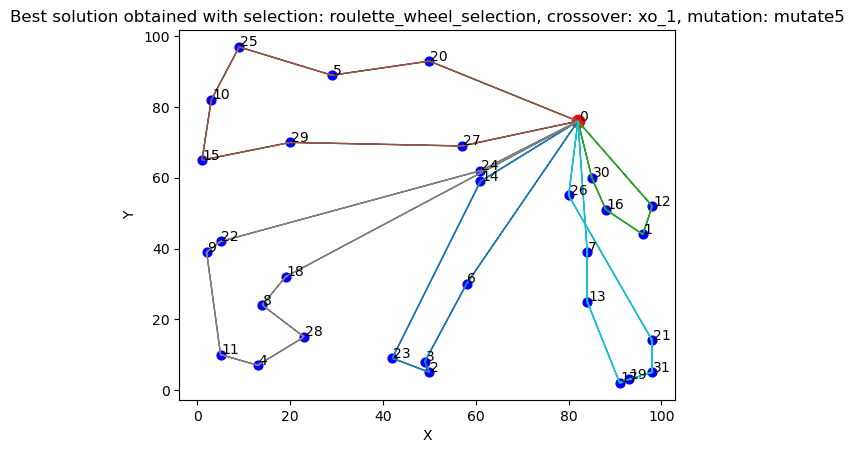

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_1. Mutation Type: mutate6
Best fitness: 811.98. Best solution: [[5, 3, 13, 30, 2, 25, 21, 16, 12, 23, 28, 10, 15, 9, 4, 24, 11, 27, 8, 22, 18, 14, 31, 1, 7, 19, 26, 17, 6, 29, 20], [1, 3, 0, 2, 3, 1, 0, 2, 2, 3, 3, 1, 1, 1, 3, 4, 3, 4, 3, 1, 3, 3, 0, 2, 2, 0, 2, 0, 0, 1, 1]].
Average fitness benchmarks: {0: inf, 100: 858.26, 200: 851.5, 300: 847.69, 400: 846.99, 500: 846.03, 600: 845.14, 700: 843.53, 800: 842.99, 900: 842.13, 1000: 840.91, 1100: 840.84, 1200: 840.84, 1300: 839.72, 1400: 839.72, 1500: 839.72, 1600: 839.62, 1700: 839.62, 1800: 839.5, 1900: 839.14, 2000: 839.14, 2100: 839.14, 2200: 838.55, 2300: 838.55, 2400: 838.55, 2500: 838.55, 2600: 838.55, 2700: 838.55, 2800: 838.54, 2900: 838.54, 3000: 838.54}


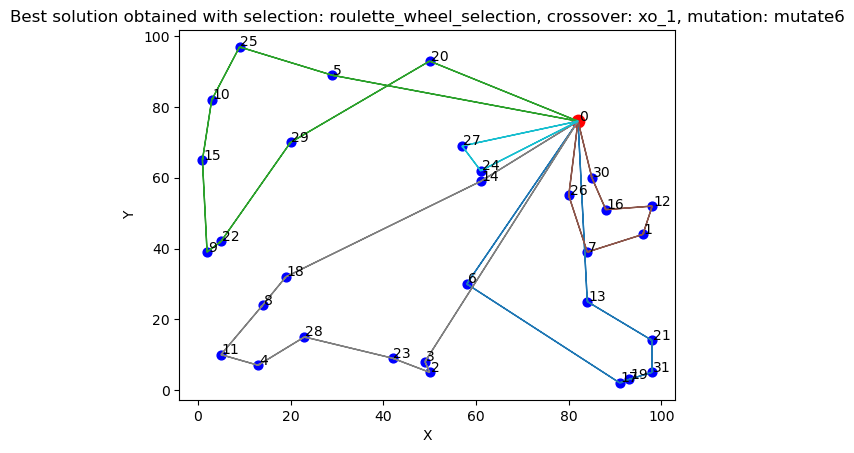

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_2. Mutation Type: mutate1
Best fitness: 830.3. Best solution: [[16, 6, 23, 27, 24, 28, 29, 4, 3, 7, 2, 17, 11, 19, 15, 14, 31, 8, 18, 9, 21, 26, 13, 10, 30, 25, 1, 22, 5, 12, 20], [3, 2, 2, 0, 1, 2, 0, 2, 4, 3, 4, 4, 2, 4, 0, 1, 4, 2, 2, 2, 4, 4, 3, 0, 1, 0, 3, 2, 0, 3, 0]].
Average fitness benchmarks: {0: inf, 100: 853.44, 200: 849.94, 300: 849.29, 400: 848.05, 500: 847.9, 600: 847.55, 700: 847.31, 800: 846.83, 900: 845.34, 1000: 845.26, 1100: 844.16, 1200: 844.16, 1300: 843.48, 1400: 842.62, 1500: 842.62, 1600: 841.79, 1700: 841.22, 1800: 841.22, 1900: 841.22, 2000: 841.22, 2100: 841.08, 2200: 841.08, 2300: 841.03, 2400: 841.03, 2500: 840.65, 2600: 840.28, 2700: 840.28, 2800: 840.28, 2900: 840.28, 3000: 840.28}


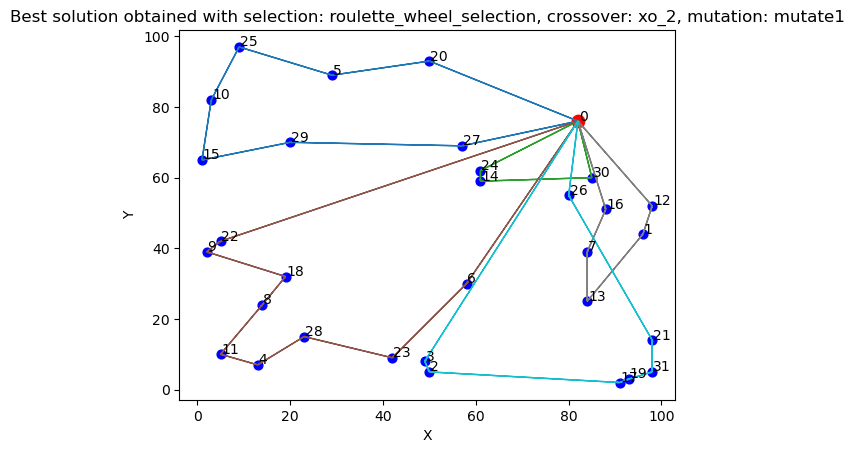

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_2. Mutation Type: mutate2
Best fitness: 831.02. Best solution: [[22, 21, 30, 9, 11, 31, 4, 19, 27, 17, 16, 29, 15, 14, 23, 10, 1, 28, 8, 18, 2, 3, 24, 13, 7, 6, 25, 12, 5, 26, 20], [1, 4, 2, 1, 1, 4, 1, 4, 3, 4, 2, 3, 3, 0, 0, 3, 2, 1, 1, 1, 0, 0, 1, 4, 4, 0, 3, 2, 3, 4, 3]].
Average fitness benchmarks: {0: inf, 100: 850.45, 200: 847.4, 300: 844.77, 400: 840.85, 500: 838.88, 600: 837.43, 700: 837.43, 800: 837.03, 900: 837.03, 1000: 836.95, 1100: 836.95, 1200: 836.91, 1300: 836.91, 1400: 836.05, 1500: 836.05, 1600: 836.05, 1700: 835.47, 1800: 835.47, 1900: 835.31, 2000: 835.25, 2100: 835.21, 2200: 835.21, 2300: 835.21, 2400: 835.21, 2500: 835.21, 2600: 835.21, 2700: 835.19, 2800: 835.19, 2900: 835.1, 3000: 835.1}


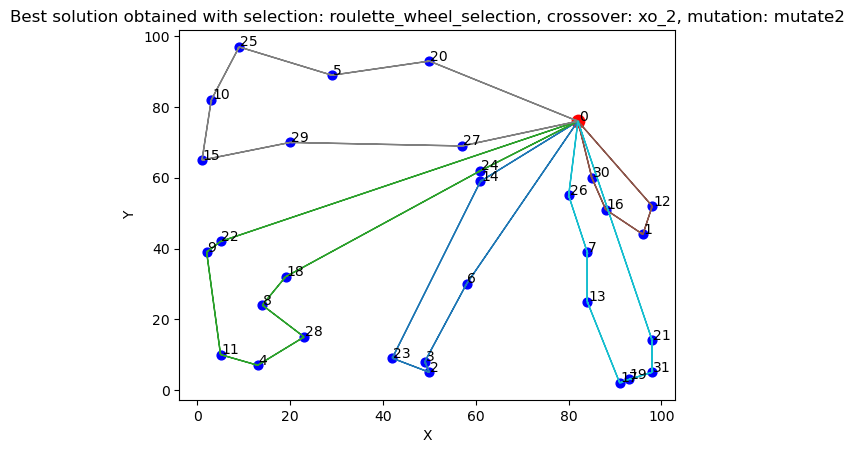

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_2. Mutation Type: mutate3
Best fitness: 869.95. Best solution: [[30, 26, 7, 24, 20, 5, 25, 10, 14, 18, 13, 17, 15, 19, 8, 12, 11, 6, 31, 28, 9, 21, 4, 22, 27, 29, 1, 23, 2, 3, 16], [4, 3, 3, 1, 0, 0, 0, 0, 2, 1, 3, 3, 0, 3, 1, 4, 1, 2, 3, 2, 2, 3, 1, 2, 2, 0, 4, 1, 1, 1, 4]].
Average fitness benchmarks: {0: inf, 100: 928.26, 200: 916.74, 300: 914.19, 400: 912.98, 500: 912.54, 600: 911.97, 700: 911.61, 800: 911.61, 900: 910.35, 1000: 910.2, 1100: 909.84, 1200: 909.49, 1300: 909.49, 1400: 909.49, 1500: 908.96, 1600: 908.94, 1700: 908.83, 1800: 908.83, 1900: 908.79, 2000: 908.79, 2100: 908.76, 2200: 908.66, 2300: 908.66, 2400: 907.27, 2500: 907.2, 2600: 907.2, 2700: 907.02, 2800: 906.95, 2900: 906.92, 3000: 906.92}


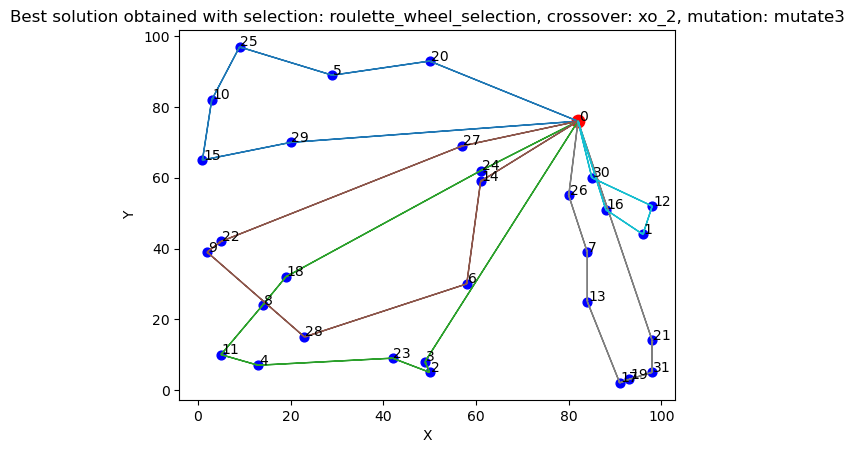

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_2. Mutation Type: mutate4
Best fitness: 830.92. Best solution: [[6, 23, 28, 4, 27, 3, 24, 2, 12, 11, 29, 8, 15, 1, 10, 14, 18, 26, 17, 30, 13, 19, 25, 31, 5, 9, 21, 20, 7, 16, 22], [0, 0, 0, 0, 4, 3, 1, 3, 2, 0, 4, 0, 4, 2, 4, 1, 0, 1, 3, 1, 2, 3, 4, 3, 4, 0, 3, 4, 2, 2, 0]].
Average fitness benchmarks: {0: inf, 100: 884.0, 200: 879.84, 300: 876.83, 400: 874.82, 500: 874.82, 600: 873.47, 700: 871.93, 800: 871.93, 900: 870.37, 1000: 870.37, 1100: 870.11, 1200: 869.46, 1300: 869.4, 1400: 869.32, 1500: 867.69, 1600: 867.65, 1700: 867.42, 1800: 867.31, 1900: 867.31, 2000: 867.31, 2100: 867.1, 2200: 867.1, 2300: 867.1, 2400: 866.96, 2500: 866.96, 2600: 866.93, 2700: 866.93, 2800: 866.93, 2900: 866.93, 3000: 866.82}


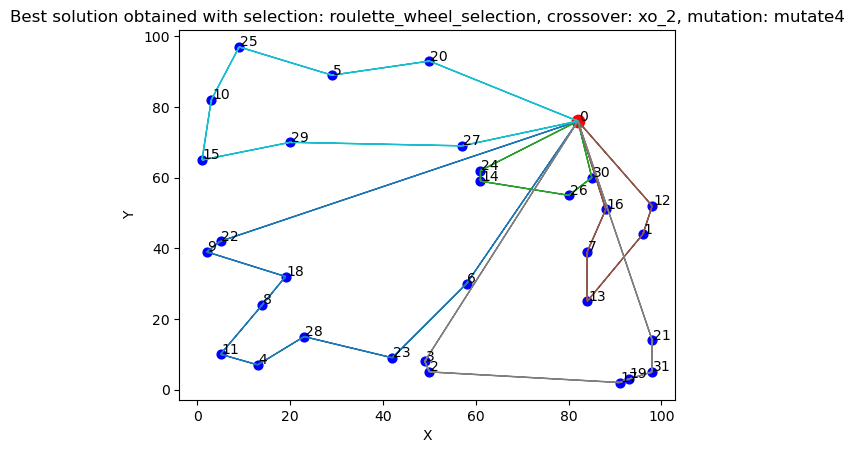

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_2. Mutation Type: mutate5
Best fitness: 861.42. Best solution: [[20, 21, 31, 29, 22, 16, 6, 19, 17, 27, 28, 7, 2, 24, 3, 14, 13, 23, 9, 26, 4, 1, 15, 11, 30, 12, 8, 18, 10, 25, 5], [4, 1, 1, 4, 4, 3, 0, 1, 1, 2, 0, 3, 1, 2, 1, 2, 3, 1, 4, 2, 0, 3, 4, 0, 2, 3, 0, 0, 4, 4, 4]].
Average fitness benchmarks: {0: inf, 100: 899.77, 200: 896.48, 300: 895.35, 400: 894.07, 500: 893.65, 600: 892.51, 700: 892.37, 800: 891.52, 900: 891.52, 1000: 891.4, 1100: 890.15, 1200: 890.15, 1300: 889.9, 1400: 889.9, 1500: 889.9, 1600: 889.83, 1700: 889.56, 1800: 889.22, 1900: 888.97, 2000: 888.46, 2100: 887.33, 2200: 887.33, 2300: 887.28, 2400: 887.28, 2500: 887.28, 2600: 887.16, 2700: 887.16, 2800: 887.16, 2900: 887.16, 3000: 887.05}


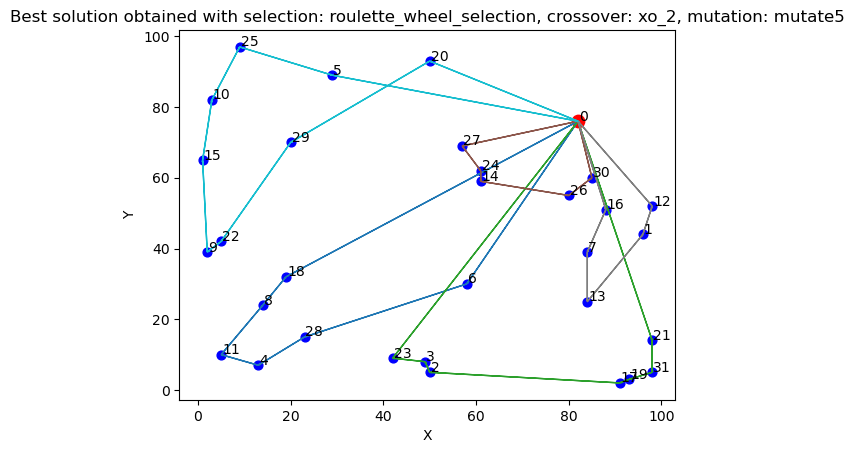

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_2. Mutation Type: mutate6
Best fitness: 831.02. Best solution: [[24, 18, 30, 8, 28, 26, 7, 16, 13, 4, 14, 20, 17, 1, 11, 5, 19, 23, 25, 31, 10, 9, 22, 15, 21, 12, 2, 3, 29, 27, 6], [0, 0, 3, 0, 0, 2, 2, 3, 2, 0, 4, 1, 2, 3, 0, 1, 2, 4, 1, 2, 1, 0, 0, 1, 2, 3, 4, 4, 1, 1, 4]].
Average fitness benchmarks: {0: inf, 100: 856.83, 200: 854.15, 300: 851.72, 400: 849.24, 500: 848.5, 600: 847.75, 700: 846.93, 800: 846.59, 900: 846.59, 1000: 845.67, 1100: 843.0, 1200: 842.62, 1300: 841.58, 1400: 841.48, 1500: 841.46, 1600: 841.46, 1700: 841.46, 1800: 841.43, 1900: 841.43, 2000: 841.43, 2100: 841.13, 2200: 841.07, 2300: 841.05, 2400: 840.63, 2500: 840.63, 2600: 840.63, 2700: 840.63, 2800: 840.63, 2900: 840.55, 3000: 840.55}


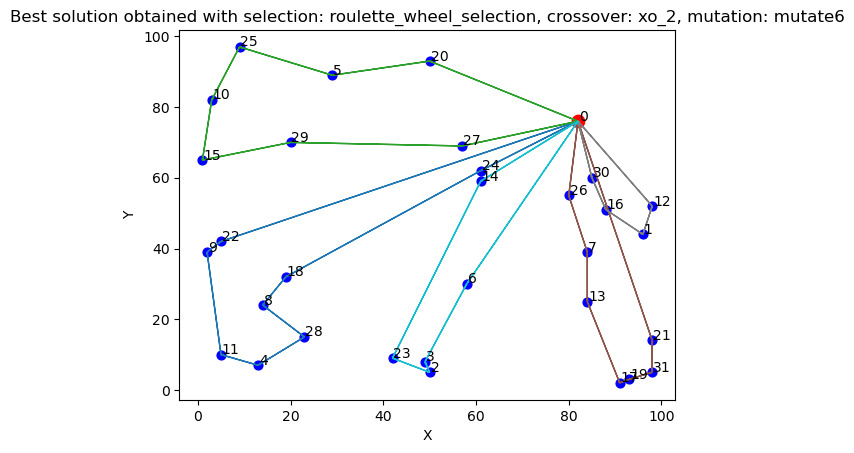

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_3. Mutation Type: mutate1
Best fitness: 803.13. Best solution: [[18, 30, 8, 29, 13, 22, 21, 11, 31, 19, 4, 28, 17, 23, 9, 15, 6, 10, 14, 27, 24, 16, 25, 5, 7, 20, 2, 1, 3, 26, 12], [2, 1, 2, 0, 3, 0, 3, 2, 3, 3, 2, 2, 3, 2, 0, 0, 3, 0, 3, 4, 4, 1, 0, 0, 1, 0, 2, 1, 2, 2, 1]].
Average fitness benchmarks: {0: inf, 100: 817.43, 200: 816.24, 300: 813.26, 400: 811.45, 500: 810.37, 600: 808.94, 700: 808.94, 800: 808.94, 900: 808.94, 1000: 808.94, 1100: 808.93, 1200: 808.91, 1300: 808.91, 1400: 808.91, 1500: 808.91, 1600: 808.9, 1700: 808.9, 1800: 808.9, 1900: 808.89, 2000: 808.89, 2100: 808.51, 2200: 808.51, 2300: 808.51, 2400: 808.51, 2500: 808.11, 2600: 808.04, 2700: 807.31, 2800: 806.86, 2900: 806.23, 3000: 806.23}


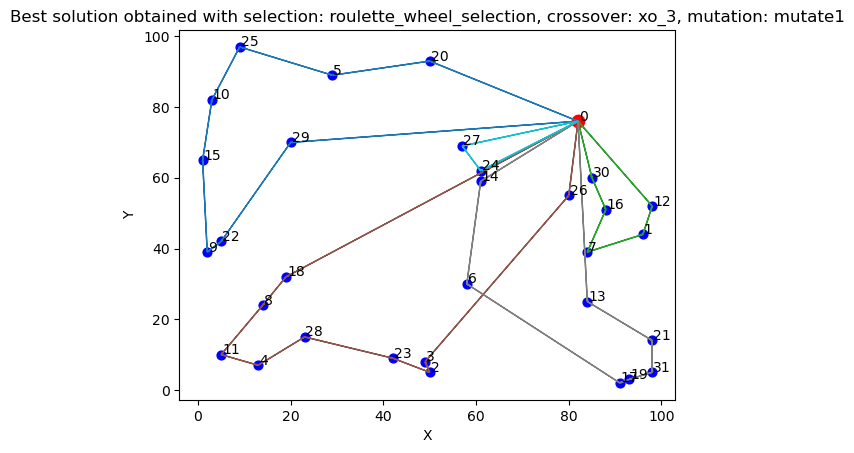

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_3. Mutation Type: mutate2
Best fitness: 839.41. Best solution: [[21, 20, 12, 29, 22, 18, 1, 8, 16, 9, 26, 11, 14, 31, 19, 24, 15, 17, 4, 28, 10, 2, 25, 6, 3, 30, 13, 7, 27, 23, 5], [0, 4, 1, 4, 4, 2, 1, 2, 1, 4, 1, 2, 3, 0, 0, 3, 4, 0, 2, 2, 4, 0, 4, 2, 0, 1, 2, 2, 3, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 870.82, 200: 866.2, 300: 862.15, 400: 859.92, 500: 858.13, 600: 857.41, 700: 856.78, 800: 856.1, 900: 855.62, 1000: 854.99, 1100: 853.34, 1200: 853.33, 1300: 853.08, 1400: 852.7, 1500: 852.26, 1600: 851.9, 1700: 851.17, 1800: 851.06, 1900: 850.67, 2000: 850.67, 2100: 850.66, 2200: 850.63, 2300: 850.63, 2400: 850.54, 2500: 850.12, 2600: 849.95, 2700: 849.95, 2800: 849.95, 2900: 849.65, 3000: 849.65}


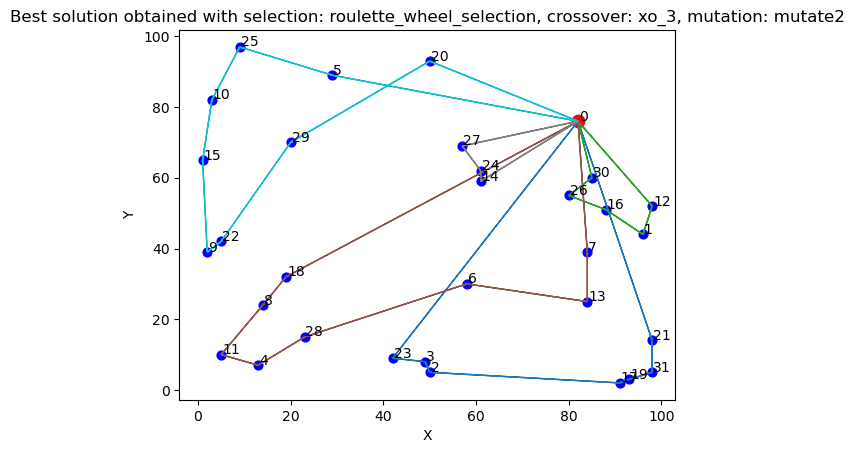

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_3. Mutation Type: mutate3
Best fitness: 986.23. Best solution: [[12, 30, 26, 27, 18, 1, 29, 9, 25, 8, 31, 11, 10, 16, 20, 17, 5, 24, 6, 15, 23, 4, 22, 19, 3, 28, 2, 13, 7, 14, 21], [4, 3, 3, 0, 1, 4, 0, 1, 0, 1, 3, 1, 0, 4, 2, 3, 2, 2, 2, 0, 2, 1, 0, 3, 2, 1, 2, 3, 3, 1, 2]].
Average fitness benchmarks: {0: inf, 100: 1004.13, 200: 996.47, 300: 993.46, 400: 992.62, 500: 991.13, 600: 990.97, 700: 989.99, 800: 988.0, 900: 988.0, 1000: 988.0, 1100: 988.0, 1200: 988.0, 1300: 988.0, 1400: 987.86, 1500: 987.55, 1600: 987.55, 1700: 987.44, 1800: 987.44, 1900: 987.44, 2000: 987.44, 2100: 987.44, 2200: 987.44, 2300: 987.44, 2400: 987.44, 2500: 987.44, 2600: 987.44, 2700: 987.44, 2800: 987.44, 2900: 987.44, 3000: 987.44}


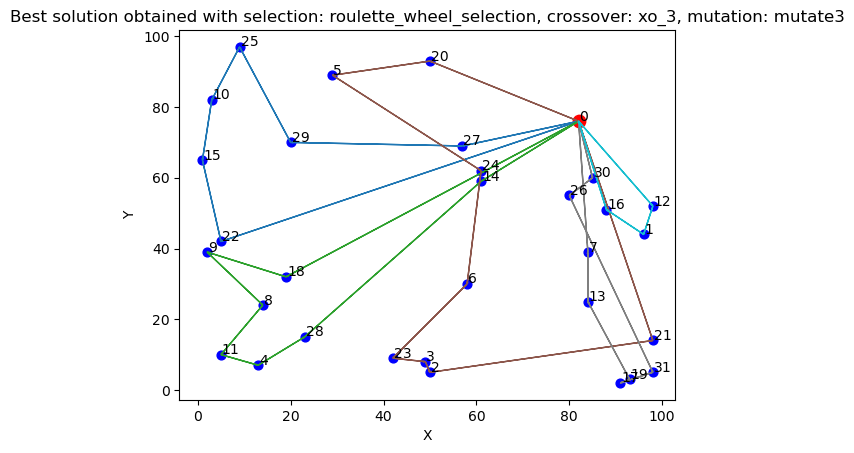

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_3. Mutation Type: mutate4
Best fitness: 1020.25. Best solution: [[20, 25, 7, 14, 31, 16, 10, 17, 5, 9, 6, 8, 12, 28, 23, 1, 30, 21, 19, 29, 3, 15, 2, 13, 4, 18, 24, 27, 26, 11, 22], [3, 3, 4, 0, 4, 2, 3, 4, 3, 0, 4, 0, 1, 0, 0, 1, 2, 1, 1, 3, 0, 3, 0, 1, 0, 0, 4, 4, 1, 3, 3]].
Average fitness benchmarks: {0: inf, 100: 1029.88, 200: 1025.95, 300: 1024.65, 400: 1024.26, 500: 1023.66, 600: 1023.36, 700: 1022.5, 800: 1022.0, 900: 1021.16, 1000: 1021.16, 1100: 1021.16, 1200: 1021.12, 1300: 1021.12, 1400: 1020.6, 1500: 1020.6, 1600: 1020.6, 1700: 1020.6, 1800: 1020.6, 1900: 1020.6, 2000: 1020.6, 2100: 1020.6, 2200: 1020.6, 2300: 1020.6, 2400: 1020.6, 2500: 1020.48, 2600: 1020.48, 2700: 1020.48, 2800: 1020.48, 2900: 1020.48, 3000: 1020.48}


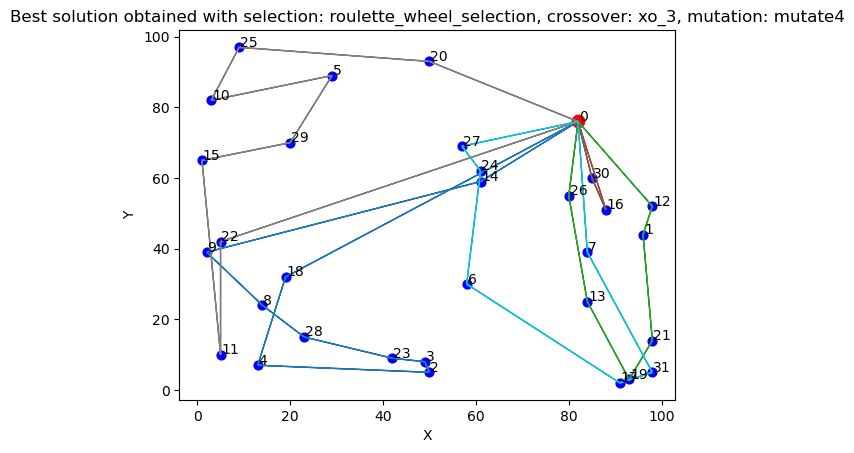

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_3. Mutation Type: mutate5
Best fitness: 833.09. Best solution: [[27, 22, 29, 21, 24, 15, 14, 23, 10, 31, 2, 9, 18, 8, 3, 11, 25, 19, 4, 30, 6, 17, 16, 13, 5, 1, 7, 28, 12, 26, 20], [3, 3, 2, 4, 1, 2, 1, 1, 2, 4, 1, 3, 3, 3, 1, 3, 2, 4, 3, 0, 1, 4, 0, 4, 2, 0, 4, 3, 0, 4, 2]].
Average fitness benchmarks: {0: inf, 100: 850.22, 200: 843.08, 300: 838.17, 400: 836.88, 500: 836.07, 600: 835.45, 700: 834.69, 800: 834.62, 900: 834.51, 1000: 834.51, 1100: 834.51, 1200: 834.51, 1300: 834.51, 1400: 834.51, 1500: 834.51, 1600: 834.51, 1700: 834.51, 1800: 834.51, 1900: 834.51, 2000: 834.51, 2100: 834.51, 2200: 834.51, 2300: 834.51, 2400: 834.51, 2500: 834.51, 2600: 834.51, 2700: 834.36, 2800: 834.36, 2900: 834.36, 3000: 834.35}


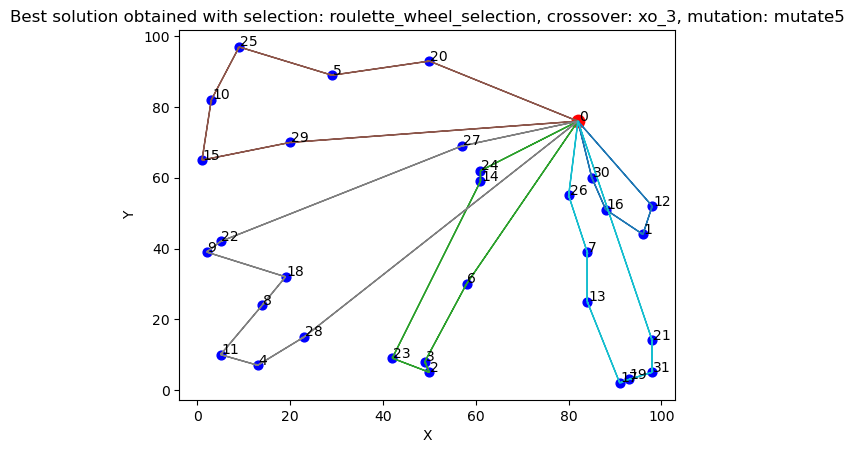

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_3. Mutation Type: mutate6
Best fitness: 832.99. Best solution: [[14, 23, 22, 9, 20, 18, 21, 8, 5, 11, 31, 25, 4, 2, 10, 28, 12, 3, 1, 16, 15, 29, 27, 6, 24, 19, 30, 17, 13, 7, 26], [1, 1, 0, 0, 3, 0, 2, 0, 3, 0, 2, 3, 0, 1, 3, 0, 4, 1, 4, 4, 3, 3, 3, 1, 0, 2, 4, 2, 2, 2, 2]].
Average fitness benchmarks: {0: inf, 100: 868.66, 200: 865.53, 300: 864.08, 400: 862.62, 500: 861.1, 600: 859.78, 700: 857.23, 800: 856.4, 900: 855.15, 1000: 854.63, 1100: 854.61, 1200: 854.13, 1300: 853.81, 1400: 853.06, 1500: 852.75, 1600: 852.75, 1700: 852.75, 1800: 852.72, 1900: 852.7, 2000: 852.38, 2100: 852.38, 2200: 852.38, 2300: 852.35, 2400: 852.35, 2500: 852.35, 2600: 852.23, 2700: 852.23, 2800: 851.93, 2900: 851.83, 3000: 851.83}


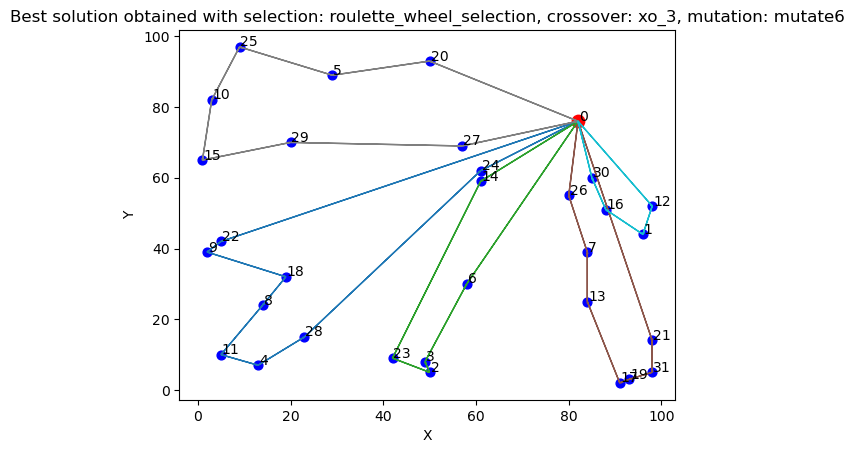

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_4. Mutation Type: mutate1
Best fitness: 787.08. Best solution: [[18, 14, 8, 27, 9, 22, 15, 28, 21, 11, 31, 4, 30, 19, 23, 29, 16, 17, 10, 2, 25, 3, 13, 1, 6, 12, 5, 7, 20, 24, 26], [2, 1, 2, 3, 2, 2, 2, 1, 4, 1, 4, 1, 0, 4, 1, 2, 0, 4, 2, 1, 2, 1, 4, 0, 1, 0, 2, 4, 2, 3, 4]].
Average fitness benchmarks: {0: inf, 100: 802.46, 200: 796.73, 300: 794.12, 400: 793.28, 500: 792.19, 600: 790.98, 700: 790.75, 800: 789.31, 900: 789.01, 1000: 788.9, 1100: 788.9, 1200: 788.83, 1300: 788.83, 1400: 788.83, 1500: 788.83, 1600: 788.83, 1700: 788.79, 1800: 787.97, 1900: 787.97, 2000: 787.97, 2100: 787.97, 2200: 787.79, 2300: 787.79, 2400: 787.79, 2500: 787.79, 2600: 787.79, 2700: 787.79, 2800: 787.79, 2900: 787.79, 3000: 787.79}


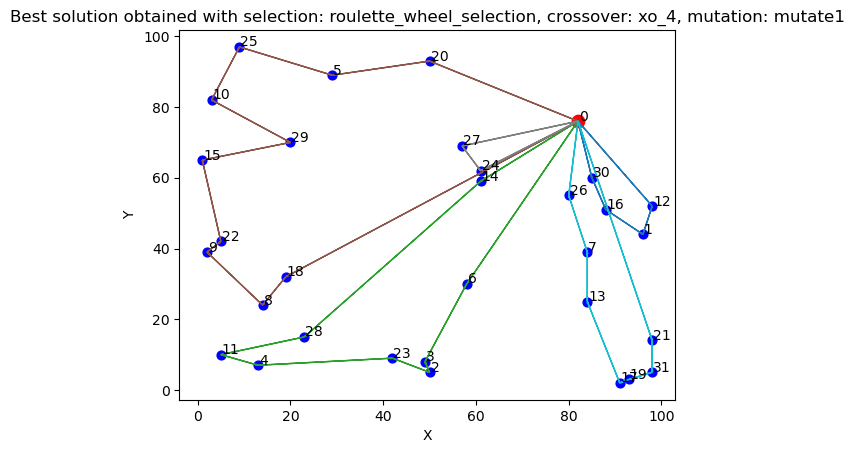

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_4. Mutation Type: mutate2
Best fitness: 798.94. Best solution: [[12, 26, 3, 29, 6, 22, 9, 1, 2, 15, 23, 17, 28, 4, 10, 19, 31, 21, 27, 11, 25, 7, 13, 24, 8, 16, 18, 5, 14, 30, 20], [2, 1, 1, 3, 4, 3, 3, 2, 1, 3, 1, 4, 1, 1, 3, 4, 4, 4, 0, 1, 3, 2, 4, 0, 1, 2, 1, 3, 1, 2, 3]].
Average fitness benchmarks: {0: inf, 100: 827.6, 200: 823.49, 300: 820.37, 400: 817.97, 500: 816.75, 600: 814.46, 700: 813.8, 800: 813.51, 900: 813.42, 1000: 813.36, 1100: 812.09, 1200: 811.66, 1300: 811.6, 1400: 811.6, 1500: 811.6, 1600: 811.6, 1700: 811.6, 1800: 811.6, 1900: 811.6, 2000: 811.6, 2100: 811.6, 2200: 811.6, 2300: 811.6, 2400: 811.6, 2500: 811.6, 2600: 811.6, 2700: 811.6, 2800: 811.6, 2900: 811.6, 3000: 811.52}


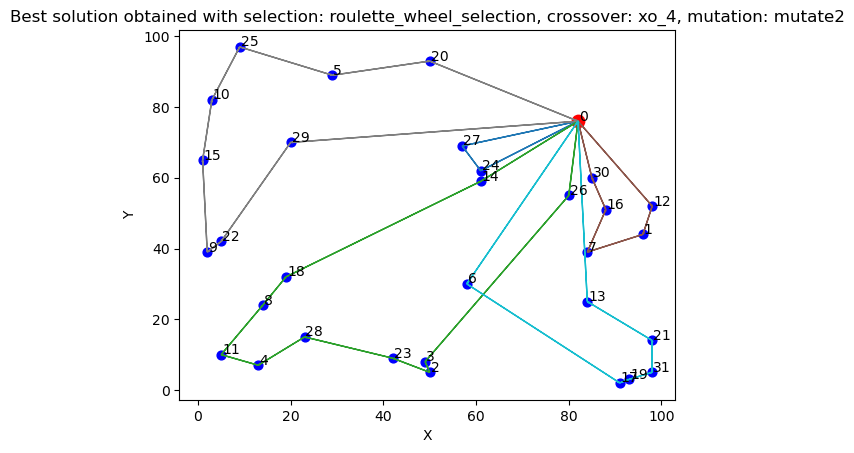

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_4. Mutation Type: mutate3
Best fitness: 914.85. Best solution: [[30, 6, 4, 11, 29, 20, 22, 8, 5, 10, 21, 9, 18, 28, 23, 7, 14, 31, 19, 1, 3, 25, 17, 24, 12, 15, 2, 26, 13, 16, 27], [0, 3, 3, 3, 4, 1, 4, 3, 1, 1, 2, 4, 3, 4, 4, 0, 3, 2, 2, 0, 4, 1, 2, 3, 0, 1, 4, 4, 2, 2, 1]].
Average fitness benchmarks: {0: inf, 100: 944.33, 200: 938.41, 300: 937.0, 400: 936.53, 500: 936.53, 600: 936.53, 700: 936.53, 800: 936.49, 900: 936.39, 1000: 936.38, 1100: 936.38, 1200: 935.83, 1300: 935.68, 1400: 935.68, 1500: 935.45, 1600: 935.45, 1700: 935.03, 1800: 934.96, 1900: 934.96, 2000: 934.96, 2100: 934.96, 2200: 934.96, 2300: 934.86, 2400: 934.86, 2500: 934.86, 2600: 934.86, 2700: 934.86, 2800: 934.86, 2900: 934.71, 3000: 934.71}


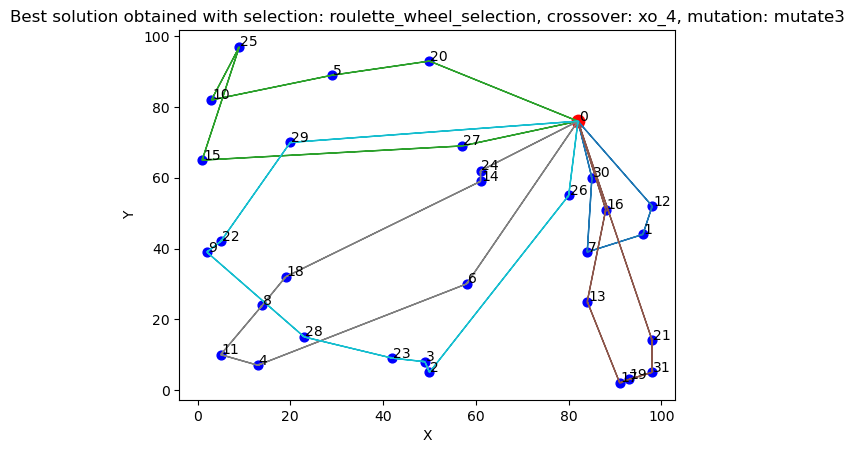

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_4. Mutation Type: mutate4
Best fitness: 945.15. Best solution: [[27, 9, 4, 14, 29, 12, 2, 31, 15, 10, 28, 8, 19, 1, 26, 25, 17, 3, 23, 20, 11, 21, 13, 22, 6, 7, 18, 16, 24, 30, 5], [4, 0, 0, 2, 4, 3, 2, 1, 4, 4, 0, 0, 1, 3, 3, 4, 1, 2, 2, 4, 0, 1, 1, 0, 2, 1, 0, 2, 0, 2, 4]].
Average fitness benchmarks: {0: inf, 100: 994.44, 200: 989.03, 300: 985.43, 400: 984.23, 500: 982.52, 600: 981.76, 700: 981.12, 800: 980.2, 900: 980.2, 1000: 979.95, 1100: 979.13, 1200: 979.13, 1300: 979.06, 1400: 978.26, 1500: 977.38, 1600: 976.99, 1700: 976.75, 1800: 976.75, 1900: 976.64, 2000: 976.64, 2100: 976.55, 2200: 976.21, 2300: 976.21, 2400: 976.21, 2500: 976.21, 2600: 976.21, 2700: 976.21, 2800: 976.21, 2900: 976.21, 3000: 976.21}


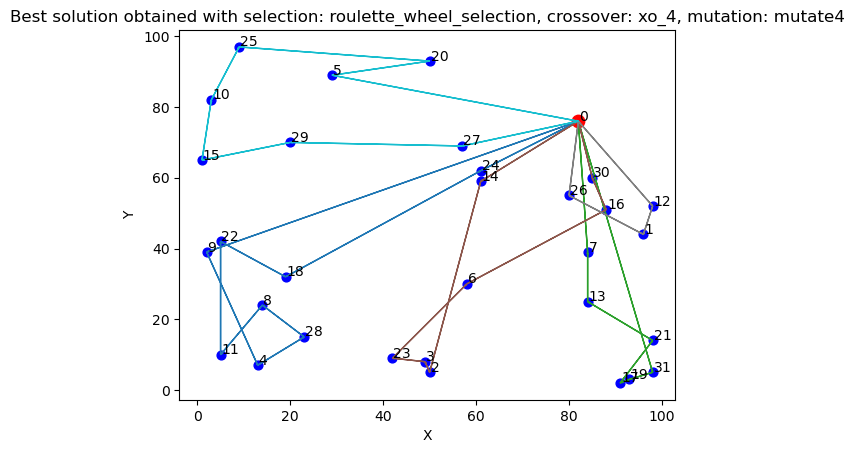

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_4. Mutation Type: mutate5
Best fitness: 853.69. Best solution: [[21, 27, 3, 30, 31, 2, 23, 4, 29, 19, 11, 15, 17, 16, 28, 10, 22, 25, 5, 13, 20, 1, 9, 8, 12, 18, 6, 14, 7, 26, 24], [4, 2, 3, 1, 4, 3, 3, 3, 0, 4, 3, 0, 4, 1, 3, 0, 2, 0, 0, 4, 0, 1, 2, 2, 1, 2, 3, 2, 4, 4, 2]].
Average fitness benchmarks: {0: inf, 100: 876.15, 200: 869.21, 300: 866.84, 400: 865.57, 500: 864.66, 600: 863.86, 700: 862.97, 800: 862.5, 900: 862.33, 1000: 862.24, 1100: 862.24, 1200: 862.18, 1300: 862.18, 1400: 861.98, 1500: 861.83, 1600: 861.83, 1700: 861.83, 1800: 861.83, 1900: 861.83, 2000: 861.69, 2100: 861.42, 2200: 861.37, 2300: 861.37, 2400: 861.37, 2500: 861.37, 2600: 861.37, 2700: 861.37, 2800: 861.37, 2900: 861.37, 3000: 861.37}


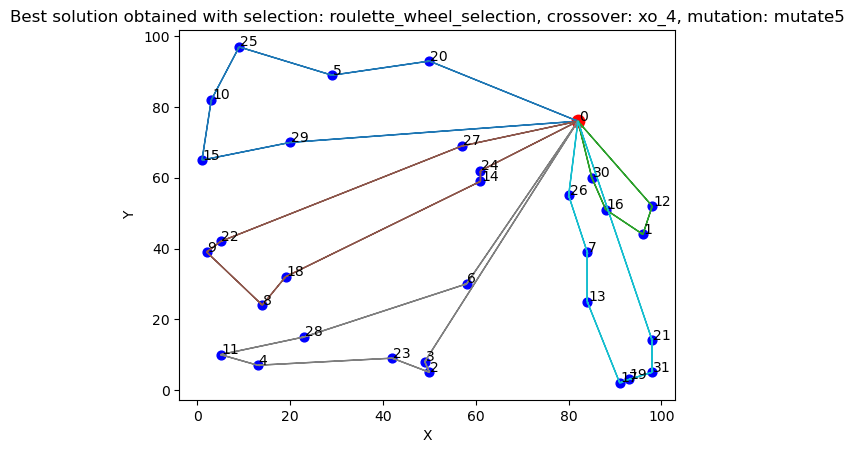

Selection algorithm: roulette_wheel_selection. Crossover Operation: xo_4. Mutation Type: mutate6
Best fitness: 834.85. Best solution: [[7, 13, 12, 27, 24, 17, 29, 15, 19, 22, 9, 14, 23, 8, 10, 25, 5, 20, 11, 4, 2, 3, 28, 1, 31, 21, 6, 16, 26, 30, 18], [1, 1, 0, 2, 4, 1, 2, 2, 1, 4, 4, 3, 3, 4, 2, 2, 2, 2, 4, 4, 3, 3, 4, 0, 1, 1, 3, 0, 1, 0, 4]].
Average fitness benchmarks: {0: inf, 100: 859.47, 200: 850.87, 300: 846.0, 400: 845.05, 500: 844.47, 600: 843.45, 700: 841.79, 800: 841.48, 900: 839.18, 1000: 838.74, 1100: 838.62, 1200: 838.55, 1300: 838.55, 1400: 838.55, 1500: 838.55, 1600: 838.54, 1700: 838.54, 1800: 838.54, 1900: 838.54, 2000: 838.54, 2100: 838.48, 2200: 838.48, 2300: 838.19, 2400: 838.07, 2500: 837.97, 2600: 837.92, 2700: 837.92, 2800: 837.58, 2900: 837.58, 3000: 837.58}


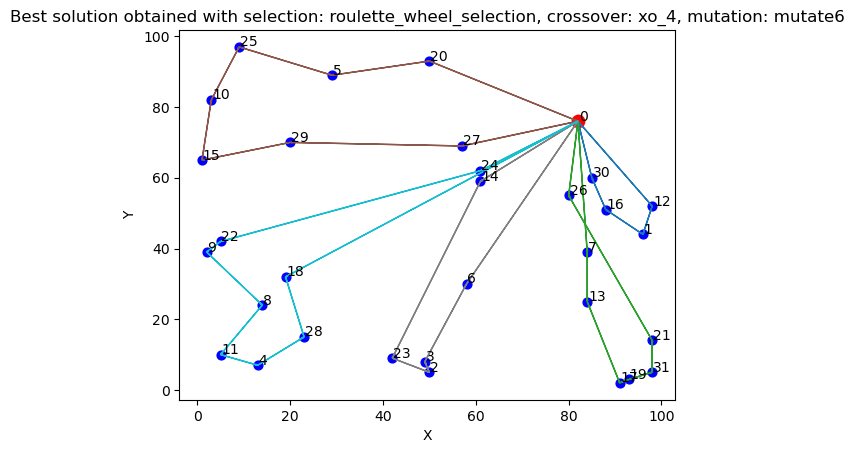

In [58]:
# "Grid search" of the different combinations of selection, xo and mutation for the genetic algorithm
selection_algorithms = [tournament_selection, ranking_selection, roulette_wheel_selection]
crossover_operations = [xo_1, xo_2, xo_3, xo_4]
mutation_types = [mutate1, mutate2, mutate3, mutate4, mutate5, mutate6]

results = []
# Iterate over each combination
for selection_algorithm in selection_algorithms:
    for crossover_operation in crossover_operations:
        for mutation_type in mutation_types:
            # Print the current combination
            print(f"Selection algorithm: {selection_algorithm.__name__}. Crossover Operation: {crossover_operation.__name__}. Mutation Type: {mutation_type.__name__}")
            # Run genetic algorithm
            best_fitness, best_solution, fitness_benchmark_all_runs = genetic_algorithm(selection_algorithm, crossover_operation, mutation_type)
            # Calculate average fitness ater 30 runs
            average_fitness_benchmarks = compute_average_fitness(fitness_benchmark_all_runs)
            # Print results
            print(f"Best fitness: {best_fitness}. Best solution: {best_solution}.")
            print(f"Average fitness benchmarks: {average_fitness_benchmarks}")
            # Plot best solution obtained for current combination
            title = f"selection: {selection_algorithm.__name__}, crossover: {crossover_operation.__name__}, mutation: {mutation_type.__name__}"
            best_routes = get_route(best_solution)
            plot_routes(best_routes, title)
            
            # Store the results
            results.append({
                'selection_algorithm': selection_algorithm.__name__,
                'crossover_operation': crossover_operation.__name__,
                'mutation_type': mutation_type.__name__,
                'best_fitness': best_fitness,
                'best_solution': best_solution,
                'average_fitness_benchmarks': average_fitness_benchmarks})

In [59]:
# Save results to a file
#with open('results.pkl', 'wb') as file:
    #pickle.dump(results, file)

# Load results from a file
#with open('results.pkl', 'rb') as file:
    #results = pickle.load(file)

In [60]:
# Sort results by best fitness
results.sort(key=lambda x: x['best_fitness'], reverse=False)

top_combinations_best_fitness = results[:5] 

for idx, result in enumerate(top_combinations_best_fitness, start=1):
    print(f"Rank {idx}: Selection: {result['selection_algorithm']}, Crossover: {result['crossover_operation']}, Mutation: {result['mutation_type']}, Best Fitness: {result['best_fitness']}")

Rank 1: Selection: roulette_wheel_selection, Crossover: xo_4, Mutation: mutate1, Best Fitness: 787.08
Rank 2: Selection: tournament_selection, Crossover: xo_4, Mutation: mutate6, Best Fitness: 788.39
Rank 3: Selection: roulette_wheel_selection, Crossover: xo_4, Mutation: mutate2, Best Fitness: 798.94
Rank 4: Selection: roulette_wheel_selection, Crossover: xo_1, Mutation: mutate4, Best Fitness: 801.85
Rank 5: Selection: roulette_wheel_selection, Crossover: xo_3, Mutation: mutate1, Best Fitness: 803.13


In [61]:
# Sort results by the last generation of the average fitness benchmarks
results.sort(key=lambda x: list(x['average_fitness_benchmarks'].values())[-1])

top20_combinations = results[:20] 

for idx, result in enumerate(top20_combinations, start=1):
    print(f"Rank {idx}: Selection: {result['selection_algorithm']}, Crossover: {result['crossover_operation']}, Mutation: {result['mutation_type']}, Average Fitness: {list(result['average_fitness_benchmarks'].values())[-1]}")

Rank 1: Selection: roulette_wheel_selection, Crossover: xo_4, Mutation: mutate1, Average Fitness: 787.79
Rank 2: Selection: tournament_selection, Crossover: xo_4, Mutation: mutate6, Average Fitness: 795.64
Rank 3: Selection: roulette_wheel_selection, Crossover: xo_1, Mutation: mutate4, Average Fitness: 805.77
Rank 4: Selection: roulette_wheel_selection, Crossover: xo_3, Mutation: mutate1, Average Fitness: 806.23
Rank 5: Selection: roulette_wheel_selection, Crossover: xo_4, Mutation: mutate2, Average Fitness: 811.52
Rank 6: Selection: tournament_selection, Crossover: xo_3, Mutation: mutate1, Average Fitness: 815.16
Rank 7: Selection: roulette_wheel_selection, Crossover: xo_3, Mutation: mutate5, Average Fitness: 834.35
Rank 8: Selection: roulette_wheel_selection, Crossover: xo_2, Mutation: mutate2, Average Fitness: 835.1
Rank 9: Selection: ranking_selection, Crossover: xo_4, Mutation: mutate1, Average Fitness: 835.7
Rank 10: Selection: tournament_selection, Crossover: xo_4, Mutation: mut

In [62]:
# Sort results by the last generation of the average fitness benchmarks
results.sort(key=lambda x: list(x['average_fitness_benchmarks'].values())[-1])

top5_combinations = results[:5] 

for idx, result in enumerate(top5_combinations, start=1):
    print(f"Rank {idx}: Selection: {result['selection_algorithm']}, Crossover: {result['crossover_operation']}, Mutation: {result['mutation_type']}, Average Fitness: {list(result['average_fitness_benchmarks'].values())[-1]}")

Rank 1: Selection: roulette_wheel_selection, Crossover: xo_4, Mutation: mutate1, Average Fitness: 787.79
Rank 2: Selection: tournament_selection, Crossover: xo_4, Mutation: mutate6, Average Fitness: 795.64
Rank 3: Selection: roulette_wheel_selection, Crossover: xo_1, Mutation: mutate4, Average Fitness: 805.77
Rank 4: Selection: roulette_wheel_selection, Crossover: xo_3, Mutation: mutate1, Average Fitness: 806.23
Rank 5: Selection: roulette_wheel_selection, Crossover: xo_4, Mutation: mutate2, Average Fitness: 811.52


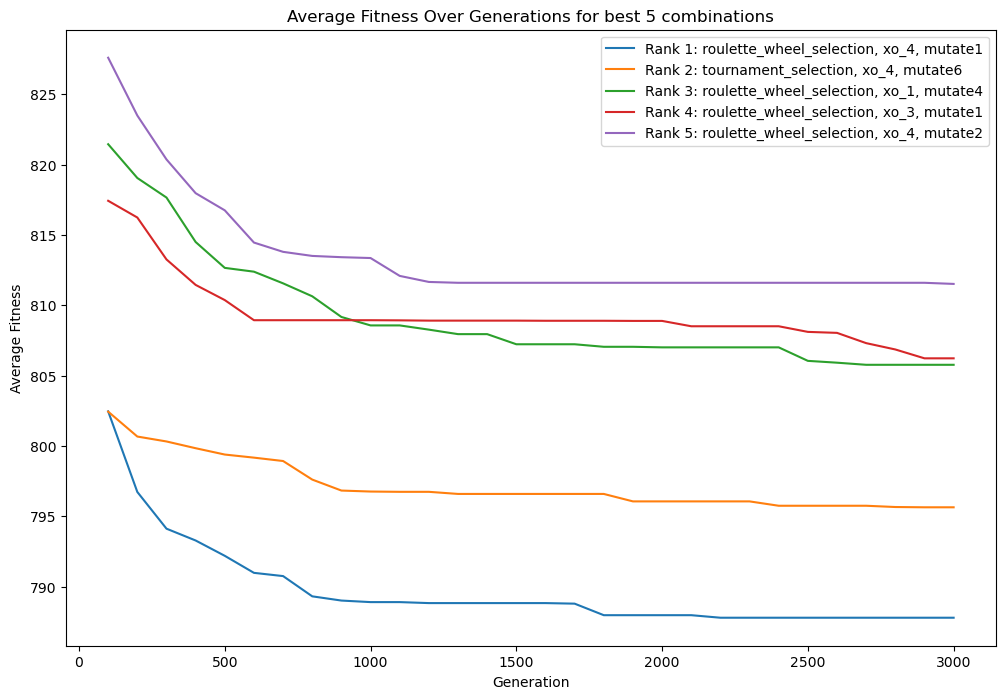

In [63]:
# Plot for evolution of the best 5 combinations
plt.figure(figsize=(12, 8))
# Plot average fitness over generations for each top combination
for idx, result in enumerate(top5_combinations, start=1):
    generations = list(result['average_fitness_benchmarks'].keys())
    average_fitness = list(result['average_fitness_benchmarks'].values())
    plt.plot(generations, average_fitness, label=f"Rank {idx}: {result['selection_algorithm']}, {result['crossover_operation']}, {result['mutation_type']}")

plt.title('Average Fitness Over Generations for best 5 combinations')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.legend()
plt.grid(False)
plt.show()

### Statistics

In [91]:
# Extract the average fitness benchmarks from the top 5 combinations
data = []
labels = []
for combination in top5_combinations:
    avg_fitness = list(combination['average_fitness_benchmarks'].values())[1:]  # Ignore the first value
    data.append(avg_fitness)
    labels.append(f"{combination['selection_algorithm']}_{combination['crossover_operation']}_{combination['mutation_type']}")

# Compute descriptive statistics
descriptive_stats = {}
for label, avg_fitness in zip(labels, data):
    descriptive_stats[label] = {
        'mean': np.mean(avg_fitness),
        'median': np.median(avg_fitness),
        'std_dev': np.std(avg_fitness),
        'min': np.min(avg_fitness),
        'max': np.max(avg_fitness),
        'Q1': np.percentile(avg_fitness, 25),
        'Q3': np.percentile(avg_fitness, 75),
        'IQR': np.percentile(avg_fitness, 75) - np.percentile(avg_fitness, 25)}

descriptive_stats_df = pd.DataFrame(descriptive_stats).T
print(descriptive_stats_df)

                                             mean   median   std_dev     min  \
roulette_wheel_selection_xo_4_mutate1  789.718667  788.830  3.187722  787.79   
tournament_selection_xo_4_mutate6      797.174000  796.590  1.762132  795.64   
roulette_wheel_selection_xo_1_mutate4  809.209333  807.230  4.057619  805.77   
roulette_wheel_selection_xo_3_mutate1  809.310667  808.905  2.395685  806.23   
roulette_wheel_selection_xo_4_mutate2  813.573333  811.600  3.863896  811.52   

                                          max      Q1        Q3     IQR  
roulette_wheel_selection_xo_4_mutate1  802.46  787.79  789.2350  1.4450  
tournament_selection_xo_4_mutate6      802.44  796.06  797.4150  1.3550  
roulette_wheel_selection_xo_1_mutate4  821.45  807.01  810.2725  3.2625  
roulette_wheel_selection_xo_3_mutate1  817.43  808.51  808.9400  0.4300  
roulette_wheel_selection_xo_4_mutate2  827.60  811.60  813.4875  1.8875  


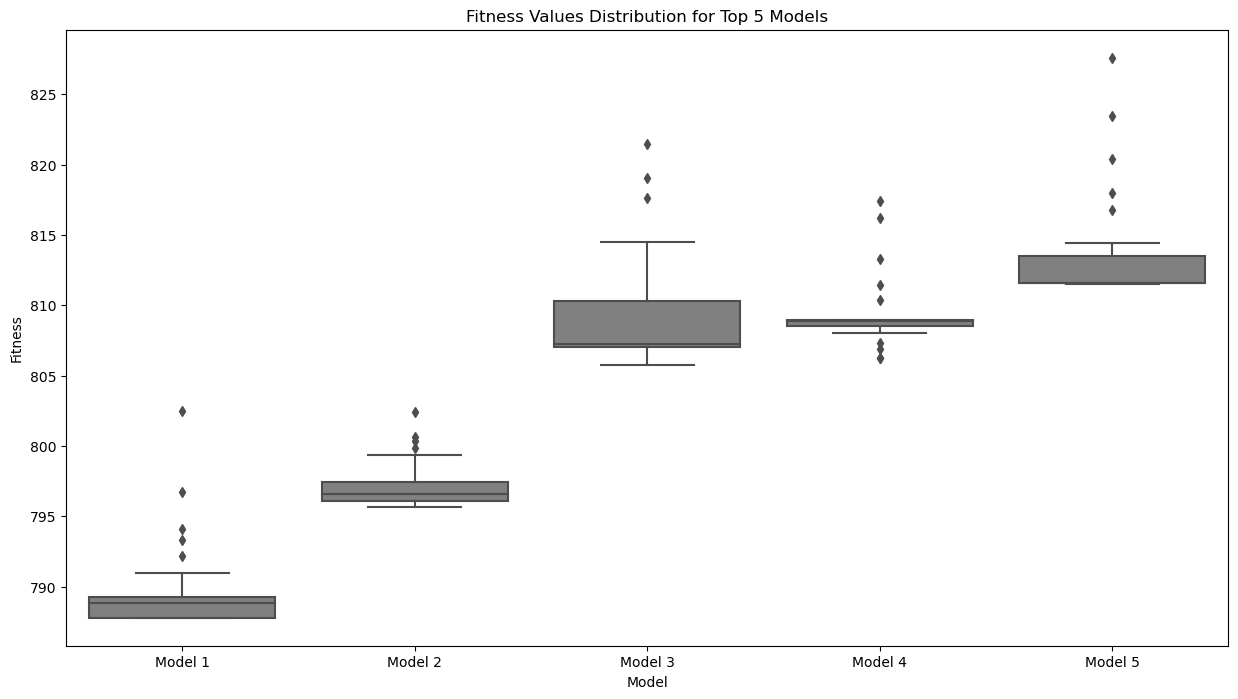

In [95]:
# Plot boxplots with descriptive statistics
plot_data = []
for i, (label, avg_fitness) in enumerate(zip(labels, data)):
    model_label = f"Model {i + 1}"
    for gen, fitness in enumerate(avg_fitness):
        plot_data.append({'Model': model_label, 'Generation': gen, 'Fitness': fitness})

plot_df = pd.DataFrame(plot_data)

# Plot using seaborn with the same color and custom labels
plt.figure(figsize=(15, 8))
sns.boxplot(x='Model', y='Fitness', data=plot_df, color='gray')
plt.title('Fitness Values Distribution for Top 5 Models')
plt.show()

In [92]:
# Kruskal-Wallis H-test to check for overall significance
kruskal_test_result = kruskal(*data)
print(f"Kruskal-Wallis H-test result: H-statistic={kruskal_test_result.statistic}, p-value={kruskal_test_result.pvalue}")

# If Kruskal-Wallis test is significant, perform pairwise comparisons using Wilcoxon rank-sum test with Bonferroni correction
if kruskal_test_result.pvalue < 0.05:
    pairwise_results = {}
    for (i, label1), (j, label2) in combinations(enumerate(labels), 2):
        stat, p = mannwhitneyu(data[i], data[j], alternative='two-sided')
        corrected_p = p * len(list(combinations(labels, 2)))  # Bonferroni correction
        pairwise_results[(label1, label2)] = corrected_p
    # Print pairwise comparisons
    for (label1, label2), p in pairwise_results.items():
        print(f"Comparison {label1} vs {label2}: p-value={p}")

Kruskal-Wallis H-test result: H-statistic=125.90304202784438, p-value=2.926527937497313e-26
Comparison roulette_wheel_selection_xo_4_mutate1 vs tournament_selection_xo_4_mutate6: p-value=2.616562224659148e-08
Comparison roulette_wheel_selection_xo_4_mutate1 vs roulette_wheel_selection_xo_1_mutate4: p-value=2.6824847628360487e-10
Comparison roulette_wheel_selection_xo_4_mutate1 vs roulette_wheel_selection_xo_3_mutate1: p-value=2.6672322904841003e-10
Comparison roulette_wheel_selection_xo_4_mutate1 vs roulette_wheel_selection_xo_4_mutate2: p-value=1.6200364246514375e-10
Comparison tournament_selection_xo_4_mutate6 vs roulette_wheel_selection_xo_1_mutate4: p-value=2.828728455777638e-10
Comparison tournament_selection_xo_4_mutate6 vs roulette_wheel_selection_xo_3_mutate1: p-value=2.812718692692767e-10
Comparison tournament_selection_xo_4_mutate6 vs roulette_wheel_selection_xo_4_mutate2: p-value=1.7123944700264012e-10
Comparison roulette_wheel_selection_xo_1_mutate4 vs roulette_wheel_select